### In this script, DBN is run on the all the sessions
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [8]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [9]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [10]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [11]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)
### separate each session based on trial types (different force levels)

In [343]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 1*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = '_allsessions'
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# force manipulation type
# SR_bothchange: self reward, both forces changed
# CO_bothchange: 1s cooperation, both forces changed
# CO_A1change: 1s cooperation, animal 1 forces changed
# CO_A2change: 1s cooperation, animal 2 forces changed
forceManiType = 'CO_A1change'

# Koala Vermelho
if 1:
    if do_bestsession:      
        # both animals' lever force were changed - Self reward
        if forceManiType == 'SR_bothchange':
            dates_list = [ "20240228","20240229","20240409","20240411",
                           "20240412","20240416","20240419",] 
            session_start_times = [ 64.5,  73.5,  0.00,  0.00,  
                                    0.00,  0.00,  0.00,  ] # in second
        # both animals' lever force were changed - cooperation
        elif forceManiType == 'CO_bothchange':
            dates_list = [ "20240304", ]
            session_start_times = [ 0.00, ] # in second
        # Koala's lever force were changed
        if forceManiType == 'CO_A1change':
            dates_list = [ "20240305","20240306","20240313","20240318","20240321",
                           "20240426","20240429","20240430"]
            session_start_times = [ 62.0,  55.2,  0.00,  0.00,  0.00, 
                                    0.00,  0.00,  0.00,  ] # in second
        # Verm's lever force were changed
        if forceManiType == 'CO_A2change':
            dates_list = [ "20240307","20240308","20240311","20240319",
                           "20240320","20240422","20240423","20240425",]
            session_start_times = [ 72.2,  0.00,  60.8,  0.00,  
                                    0.00,  53.0,  0.00,  0.00,] # in second       
    
    elif not do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      # both animals' lever force were changed - Self reward
                    #  "20240228","20240229","20240409","20240411",
                    #  "20240412","20240416","20240419",
                      # both animals' lever force were changed - cooperation
                    #  "20240304",
                      # Koala's lever force were changed
                      "20240305","20240306","20240313","20240318","20240321",
                      "20240426","20240429","20240429",
                      # Verm's lever force were changed
                      "20240307","20240308","20240311","20240319",
                      "20240320","20240422","20240423","20240425",
                     ]
        session_start_times = [ 
                                # both animals' lever force were changed - Self reward
                        #        64.5,  73.5,  0.00,  0.00,  
                        #        0.00,  0.00,  0.00, 
                                # both animals' lever force were changed - cooperation
                        #        0.00,  
                                # Koala's lever force were changed
                                62.0,  55.2,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,
                                # Verm's lever force were changed
                                72.2,  0.00,  60.8,  0.00,  
                                0.00,  53.0,  0.00,  0.00,
                              ] # in second
    
    animal1_fixedorder = ['koala']
    animal2_fixedorder = ['vermelho']

    animal1_filename = "Koala"
    animal2_filename = "Vermelho"
    
#    
# dates_list = ["20240430"]
# session_start_times = [0.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables  
# align the animal1 and animal2 across the sessions to the right animal1 and 2 fixed_order
animal1_name_all_dates = np.empty(shape=(0,), dtype=str)
animal2_name_all_dates = np.empty(shape=(0,), dtype=str)
trialdates_all_dates = np.empty(shape=(0,), dtype=str)
tasktypes_all_dates = np.zeros((0,))
coopthres_all_dates = np.zeros((0,))
force1_all_dates = np.zeros((0,)) 
force2_all_dates = np.zeros((0,)) 

subblockID_all_dates = np.zeros((0,))

succ_rate_all_dates = np.zeros((0,))
trialnum_all_dates = np.zeros((0,))
blocktime_all_dates = np.zeros((0,))

interpullintv_all_dates = np.zeros((0,))
pull1_IPI_all_dates = np.zeros((0,))
pull2_IPI_all_dates = np.zeros((0,))
pull1_IPI_std_all_dates = np.zeros((0,))
pull2_IPI_std_all_dates = np.zeros((0,))

owgaze1_num_all_dates = np.zeros((0,))
owgaze2_num_all_dates = np.zeros((0,))
mtgaze1_num_all_dates = np.zeros((0,))
mtgaze2_num_all_dates = np.zeros((0,))
pull1_num_all_dates = np.zeros((0,))
pull2_num_all_dates = np.zeros((0,))

lever1_holdtime_all_dates = np.zeros((0,))
lever2_holdtime_all_dates = np.zeros((0,))
lever1_holdtime_std_all_dates = np.zeros((0,))
lever2_holdtime_std_all_dates = np.zeros((0,))

lever1_gauge_all_dates = np.zeros((0,))
lever2_gauge_all_dates = np.zeros((0,))
lever1_gauge_std_all_dates = np.zeros((0,))
lever2_gauge_std_all_dates = np.zeros((0,))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_forceManipulation_task_data_saved/'


    

In [344]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    
    print('load basic data for '+forceManiType)
    
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
   
    with open(data_saved_subfolder+'/animal1_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        animal1_name_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/animal2_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        animal2_name_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialdates_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        trialdates_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/force1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        force1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/force2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        force2_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/subblockID_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        subblockID_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        blocktime_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull1_IPI_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull1_IPI_std_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull2_IPI_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull2_IPI_std_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)     
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/lever1_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_holdtime_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever1_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_holdtime_std_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_holdtime_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_holdtime_std_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/lever1_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_gauge_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever1_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_gauge_std_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_gauge_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_gauge_std_all_dates = pickle.load(f)
        
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates for '+forceManiType)

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            lever_reading_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_lever_reading_" + "*.json") 
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            lever_reading = pd.read_json(lever_reading_json[0])
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            lever_reading_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_lever_reading_" + "*.json")             
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            lever_reading = pd.read_json(lever_reading_json[0])

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        # change lever reading time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(lever_reading)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = lever_reading["trial_number"]==itrial+1
            new_time_itrial = lever_reading[ind]["readout_timepoint"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        lever_reading["readout_timepoint"] = time_points_new["time_points_new"]
        lever_reading = lever_reading[lever_reading["readout_timepoint"] != 0]
        #
        lever1_pull = lever_reading[(lever_reading['lever_id']==1)&(lever_reading['pull_or_release']==1)]
        lever1_release = lever_reading[(lever_reading['lever_id']==1)&(lever_reading['pull_or_release']==0)]
        lever2_pull = lever_reading[(lever_reading['lever_id']==2)&(lever_reading['pull_or_release']==1)]
        lever2_release = lever_reading[(lever_reading['lever_id']==2)&(lever_reading['pull_or_release']==0)]
        #
        if np.shape(lever1_release)[0]<np.shape(lever1_pull)[0]:
            lever1_pull = lever1_pull.iloc[0:-1]
        if np.shape(lever2_release)[0]<np.shape(lever2_pull)[0]:
            lever2_pull = lever2_pull.iloc[0:-1]
        #
        lever1_pull_release = lever1_pull
        lever1_pull_release['delta_timepoint'] = np.array(lever1_release['readout_timepoint'].reset_index(drop=True)-lever1_pull['readout_timepoint'].reset_index(drop=True))
        lever1_pull_release['delta_gauge'] = np.array(lever1_release['strain_gauge'].reset_index(drop=True)-lever1_pull['strain_gauge'].reset_index(drop=True))
        lever2_pull_release = lever2_pull
        lever2_pull_release['delta_timepoint'] = np.array(lever2_release['readout_timepoint'].reset_index(drop=True)-lever2_pull['readout_timepoint'].reset_index(drop=True))
        lever2_pull_release['delta_gauge'] = np.array(lever2_release['strain_gauge'].reset_index(drop=True)-lever2_pull['strain_gauge'].reset_index(drop=True))
        
        
        # load behavioral event results from the tracking analysis
        if 1:
            # folder and file path
            camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_forceManipulation_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
            camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_forceManipulation_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"

            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
            try: 
                bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                # get the bodypart data from files
                bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
                video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
            except:
                bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                # get the bodypart data from files
                bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
                video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        

            try:
                # dummy
                print('load social gaze with '+cameraID+' only of '+date_tgt)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                    output_look_ornot = pickle.load(f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                    output_allvectors = pickle.load(f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                    output_allangles = pickle.load(f)  
            except:   
                print('analyze social gaze with '+cameraID+' only of '+date_tgt)
                # get social gaze information 
                output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                       considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                       sqr_thres_face,sqr_thres_body)
                # save data
                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                    pickle.dump(output_look_ornot, f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                    pickle.dump(output_allvectors, f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                    pickle.dump(output_allangles, f)


            look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
            look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
            look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
            # change the unit to second
            session_start_time = session_start_times[idate]
            look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']


            # # plot behavioral events
            if np.isin(animal1,animal1_fixedorder):
                    plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            else:
                    plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
            #
            # save behavioral events plot
            if 1:
                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")
                

            # analyze the events interval, especially for the pull to other and other to pull interval
            # could be used for define time bin for DBN
            if 1:
                _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                             oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                #
                pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
                bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                                'pull_other_pooled': pull_other_pool_itv}

            # plot the tracking demo video
            if 0: 
                tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                  lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                  animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                  animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                  video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        
             
            
        # after all the analysis, separate them based on different subblock    
        # get task type and cooperation threshold
        # tasktype: 1-normal SR, 2-force changed SR, 3-normal coop, 4-force changed coop
        trialID_list = np.array(trial_record_clean['trial_number'],dtype = 'int')
        tasktype_list = np.array(trial_record_clean['task_type'],dtype = 'int')
        coop_thres_list = np.array(trial_record_clean['pulltime_thres'],dtype = 'int')
        lever1force_list = np.array(trial_record_clean['lever1_force'],dtype = 'int')
        lever2force_list = np.array(trial_record_clean['lever2_force'],dtype = 'int')
        
        # use the combination of lever 1/2 forces to separate trials
        force12_uniques,indices = np.unique(np.vstack((lever1force_list,lever2force_list)),axis=1,return_index=True)
        force12_uniques = force12_uniques[:,np.argsort(indices)]
        ntrialtypes = np.shape(force12_uniques)[1]
        
        # 
        for itrialtype in np.arange(0,ntrialtypes,1):
            force1_unique = force12_uniques[0,itrialtype]
            force2_unique = force12_uniques[1,itrialtype]

            ind = np.isin(lever1force_list,force1_unique) & np.isin(lever2force_list,force2_unique)
            
            trialID_itrialtype = trialID_list[ind]
            
            tasktype_itrialtype = np.unique(tasktype_list[ind])
            coop_thres_itrialtype = np.unique(coop_thres_list[ind])
            
            # save some simple measures
            animal1_name_all_dates = np.append(animal1_name_all_dates,animal1)
            animal2_name_all_dates = np.append(animal2_name_all_dates,animal2)
            trialdates_all_dates = np.append(trialdates_all_dates,date_tgt)
            tasktypes_all_dates = np.append(tasktypes_all_dates,tasktype_itrialtype)
            coopthres_all_dates = np.append(coopthres_all_dates,coop_thres_itrialtype)
            #
            if np.isin(animal1,animal1_fixedorder):
                force1_all_dates = np.append(force1_all_dates,force1_unique)
                force2_all_dates = np.append(force2_all_dates,force2_unique)
            else:
                force1_all_dates = np.append(force1_all_dates,force2_unique)
                force2_all_dates = np.append(force2_all_dates,force1_unique)
            #
            trialnum_all_dates = np.append(trialnum_all_dates,np.sum(ind))
            subblockID_all_dates = np.append(subblockID_all_dates,itrialtype)
            
            # analyze behavior results
            bhv_data_itrialtype = bhv_data[np.isin(bhv_data['trial_number'],trialID_itrialtype)]
            #
            # successful rates
            succ_rate_itrialtype = np.sum((bhv_data_itrialtype['behavior_events']==3)|(bhv_data_itrialtype['behavior_events']==4))/np.sum((bhv_data_itrialtype['behavior_events']==1)|(bhv_data_itrialtype['behavior_events']==2))
            succ_rate_all_dates = np.append(succ_rate_all_dates,succ_rate_itrialtype)
            #
            # block time
            block_starttime = bhv_data_itrialtype[bhv_data_itrialtype['behavior_events']==0]['time_points'].iloc[0]
            block_endtime = bhv_data_itrialtype[bhv_data_itrialtype['behavior_events']==9]['time_points'].iloc[-1]
            blocktime_all_dates = np.append(blocktime_all_dates,block_endtime-block_starttime)
            #
            # across animal interpull interval
            pullid = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==1) | (bhv_data_itrialtype['behavior_events']==2)]["behavior_events"])
            pulltime = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==1) | (bhv_data_itrialtype['behavior_events']==2)]["time_points"])
            pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
            pulltime_diff = pulltime[1:] - pulltime[0:-1]
            interpull_intv = pulltime_diff[pullid_diff==1]
            interpull_intv = interpull_intv[interpull_intv<20]
            mean_interpull_intv = np.nanmean(interpull_intv)
            std_interpull_intv = np.nanstd(interpull_intv)
            #
            interpullintv_all_dates = np.append(interpullintv_all_dates,mean_interpull_intv)
            # 
            # animal 1 and 2's pull numbers
            if np.isin(animal1,animal1_fixedorder):
                pull1_num_all_dates = np.append(pull1_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==1))
                pull2_num_all_dates = np.append(pull2_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==2))
            else:
                pull1_num_all_dates = np.append(pull1_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==2))
                pull2_num_all_dates = np.append(pull2_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==1))
            #
            # animal 1 and 2's within animal interpull interval
            pull1time = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==1)]["time_points"])
            ipi_pull1 = pull1time[1:]-pull1time[0:-1]
            ipi_pull1 = ipi_pull1[ipi_pull1<20]
            mean_ipi_pull1 = np.nanmean(ipi_pull1)
            std_ipi_pull1 = np.nanstd(ipi_pull1)/np.sqrt(np.shape(ipi_pull1)[0])
            pull2time = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==2)]["time_points"])
            ipi_pull2 = pull2time[1:]-pull2time[0:-1]
            ipi_pull2 = ipi_pull2[ipi_pull2<20]
            mean_ipi_pull2 = np.nanmean(ipi_pull2)
            std_ipi_pull2 = np.nanstd(ipi_pull2)/np.sqrt(np.shape(ipi_pull2)[0])
            if np.isin(animal1,animal1_fixedorder):
                pull1_IPI_all_dates = np.append(pull1_IPI_all_dates,mean_ipi_pull1)
                pull2_IPI_all_dates = np.append(pull2_IPI_all_dates,mean_ipi_pull2)
                pull1_IPI_std_all_dates = np.append(pull1_IPI_std_all_dates,std_ipi_pull1)
                pull2_IPI_std_all_dates = np.append(pull2_IPI_std_all_dates,std_ipi_pull2)
            else:
                pull1_IPI_all_dates = np.append(pull1_IPI_all_dates,mean_ipi_pull2)
                pull2_IPI_all_dates = np.append(pull2_IPI_all_dates,mean_ipi_pull1)
                pull1_IPI_std_all_dates = np.append(pull1_IPI_std_all_dates,std_ipi_pull2)
                pull2_IPI_std_all_dates = np.append(pull2_IPI_std_all_dates,std_ipi_pull1)
            
            
            # lever holding time            
            lever1_holdtimes_itrialtype = lever1_pull_release[np.isin(lever1_pull_release['trial_number'],trialID_itrialtype)]['delta_timepoint']
            mean_lever1_holdtime = np.nanmean(lever1_holdtimes_itrialtype)           
            std_lever1_holdtime = np.nanstd(lever1_holdtimes_itrialtype)/np.sqrt(np.shape(lever1_holdtimes_itrialtype)[0]) 
            lever2_holdtimes_itrialtype = lever2_pull_release[np.isin(lever2_pull_release['trial_number'],trialID_itrialtype)]['delta_timepoint']
            mean_lever2_holdtime = np.nanmean(lever2_holdtimes_itrialtype)
            std_lever2_holdtime = np.nanstd(lever2_holdtimes_itrialtype)/np.sqrt(np.shape(lever2_holdtimes_itrialtype)[0])             
            if np.isin(animal1,animal1_fixedorder):
                lever1_holdtime_all_dates = np.append(lever1_holdtime_all_dates,mean_lever1_holdtime)
                lever2_holdtime_all_dates = np.append(lever2_holdtime_all_dates,mean_lever2_holdtime)
                lever1_holdtime_std_all_dates = np.append(lever1_holdtime_std_all_dates,std_lever1_holdtime)
                lever2_holdtime_std_all_dates = np.append(lever2_holdtime_std_all_dates,std_lever2_holdtime)
            else:
                lever1_holdtime_all_dates = np.append(lever1_holdtime_all_dates,mean_lever2_holdtime)
                lever2_holdtime_all_dates = np.append(lever2_holdtime_all_dates,mean_lever1_holdtime)
                lever1_holdtime_std_all_dates = np.append(lever1_holdtime_std_all_dates,std_lever2_holdtime)
                lever2_holdtime_std_all_dates = np.append(lever2_holdtime_std_all_dates,std_lever1_holdtime)
            
            # strain gauge reading
            lever1_gauge_itrialtype = lever1_pull_release[np.isin(lever1_pull_release['trial_number'],trialID_itrialtype)]['delta_gauge']
            mean_lever1_gauge = np.nanmean(lever1_gauge_itrialtype)           
            std_lever1_gauge = np.nanstd(lever1_gauge_itrialtype)/np.sqrt(np.shape(lever1_gauge_itrialtype)[0]) 
            lever2_gauge_itrialtype = lever2_pull_release[np.isin(lever2_pull_release['trial_number'],trialID_itrialtype)]['delta_gauge']
            mean_lever2_gauge = np.nanmean(lever2_gauge_itrialtype)
            std_lever2_gauge = np.nanstd(lever2_gauge_itrialtype)/np.sqrt(np.shape(lever2_gauge_itrialtype)[0])             
            if np.isin(animal1,animal1_fixedorder):
                lever1_gauge_all_dates = np.append(lever1_gauge_all_dates,mean_lever1_gauge)
                lever2_gauge_all_dates = np.append(lever2_gauge_all_dates,mean_lever2_gauge)
                lever1_gauge_std_all_dates = np.append(lever1_gauge_std_all_dates,std_lever1_gauge)
                lever2_gauge_std_all_dates = np.append(lever2_gauge_std_all_dates,std_lever2_gauge)
            else:
                lever1_gauge_all_dates = np.append(lever1_gauge_all_dates,mean_lever2_gauge)
                lever2_gauge_all_dates = np.append(lever2_gauge_all_dates,mean_lever1_gauge)
                lever1_gauge_std_all_dates = np.append(lever1_gauge_std_all_dates,std_lever2_gauge)
                lever2_gauge_std_all_dates = np.append(lever2_gauge_std_all_dates,std_lever1_gauge)

            
            # gaze number, based on the DLC tracking 
            if np.isin(animal1,animal1_fixedorder):
                owgaze1_num_all_dates = np.append(owgaze1_num_all_dates,np.shape(oneway_gaze1[(oneway_gaze1<=block_endtime)&(oneway_gaze1>=block_starttime)])[0])
                owgaze2_num_all_dates = np.append(owgaze2_num_all_dates,np.shape(oneway_gaze2[(oneway_gaze2<=block_endtime)&(oneway_gaze2>=block_starttime)])[0])
                mtgaze1_num_all_dates = np.append(mtgaze1_num_all_dates,np.shape(mutual_gaze1[(mutual_gaze1<=block_endtime)&(mutual_gaze1>=block_starttime)])[0])
                mtgaze2_num_all_dates = np.append(mtgaze2_num_all_dates,np.shape(mutual_gaze2[(mutual_gaze2<=block_endtime)&(mutual_gaze2>=block_starttime)])[0])
            else:
                owgaze1_num_all_dates = np.append(owgaze1_num_all_dates,np.shape(oneway_gaze2[(oneway_gaze2<=block_endtime)&(oneway_gaze2>=block_starttime)])[0])
                owgaze2_num_all_dates = np.append(owgaze2_num_all_dates,np.shape(oneway_gaze1[(oneway_gaze1<=block_endtime)&(oneway_gaze1>=block_starttime)])[0])
                mtgaze1_num_all_dates = np.append(mtgaze1_num_all_dates,np.shape(mutual_gaze2[(mutual_gaze2<=block_endtime)&(mutual_gaze2>=block_starttime)])[0])
                mtgaze2_num_all_dates = np.append(mtgaze2_num_all_dates,np.shape(mutual_gaze1[(mutual_gaze1<=block_endtime)&(mutual_gaze1>=block_starttime)])[0])
            
            
                
    # save data
    if 1:        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        with open(data_saved_subfolder+'/animal1_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(animal1_name_all_dates, f)
        with open(data_saved_subfolder+'/animal2_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(animal2_name_all_dates, f)
        with open(data_saved_subfolder+'/trialdates_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(trialdates_all_dates, f)
        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
            
        with open(data_saved_subfolder+'/force1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(force1_all_dates, f)
        with open(data_saved_subfolder+'/force2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(force2_all_dates, f)
            
        with open(data_saved_subfolder+'/subblockID_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(subblockID_all_dates, f)
            
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(blocktime_all_dates, f)
        
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/pull1_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull1_IPI_all_dates, f)
        with open(data_saved_subfolder+'/pull1_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull1_IPI_std_all_dates, f)
        with open(data_saved_subfolder+'/pull2_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull2_IPI_all_dates, f)
        with open(data_saved_subfolder+'/pull2_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull2_IPI_std_all_dates, f)
                
        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)       
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/lever1_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_holdtime_all_dates, f)
        with open(data_saved_subfolder+'/lever1_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_holdtime_std_all_dates, f)
        with open(data_saved_subfolder+'/lever2_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_holdtime_all_dates, f)
        with open(data_saved_subfolder+'/lever2_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_holdtime_std_all_dates, f)
        
        with open(data_saved_subfolder+'/lever1_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_gauge_all_dates, f)
        with open(data_saved_subfolder+'/lever1_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_gauge_std_all_dates, f)
        with open(data_saved_subfolder+'/lever2_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_gauge_all_dates, f)
        with open(data_saved_subfolder+'/lever2_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_gauge_std_all_dates, f)
              
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    

load basic data for CO_A1change
all data from all dates are loaded


In [345]:
np.max((owgaze1_num_all_dates+mtgaze1_num_all_dates)/blocktime_all_dates)

6.828332664156743

In [346]:
owgaze2_num_all_dates

array([ 1.,  0., 52.,  0.,  5., 34., 13., 17.,  9.,  0.,  3.,  1.,  0.,
       13.,  1.,  0., 45., 11.,  0., 32., 17.,  4., 10., 24.,  5., 12.,
        0., 17.,  3.])

### prepare the input data for DBN
#### distribution of gaze before and after pulls

In [347]:
# define DBN related summarizing variables
DBN_input_data_alltypes = dict.fromkeys(dates_list, [])

# initiate the final data set
dist_twin_range = 5
#
SameAnimal_gazeDist_mean_all = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
SameAnimal_gazeDist_mean_all[animal1_fixedorder[0]] = dict.fromkeys(dates_list,[])
SameAnimal_gazeDist_mean_all[animal2_fixedorder[0]] = dict.fromkeys(dates_list,[])
#
AcroAnimal_gazeDist_mean_all = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
AcroAnimal_gazeDist_mean_all[animal1_fixedorder[0]] = dict.fromkeys(dates_list,[])
AcroAnimal_gazeDist_mean_all[animal2_fixedorder[0]] = dict.fromkeys(dates_list,[])
#
SameAnimal_gazeDist_shuffle_all = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
SameAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]] = dict.fromkeys(dates_list,[])
SameAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]] = dict.fromkeys(dates_list,[])
#
AcroAnimal_gazeDist_shuffle_all = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
AcroAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]] = dict.fromkeys(dates_list,[])
AcroAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]] = dict.fromkeys(dates_list,[])

prepare_input_data = 0

# DBN resolutions (make sure they are the same as in the later part of the code)
totalsess_time = 600 # total session time in s
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms

mergetempRos = 0
doBhvitv_timebin = 0 # 1: if use the mean bhv event interval for time bin

if mergetempRos:
    temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    # use bhv event to decide temporal resolution
    #
    #low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
    #temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)
#
if doBhvitv_timebin:
    pull_other_intv_ii = pd.Series(bhv_intv_all_dates[date_tgt]['pull_other_pooled'])
    # remove the interval that is too large
    pull_other_intv_ii[pull_other_intv_ii>(np.nanmean(pull_other_intv_ii)+2*np.nanstd(pull_other_intv_ii))]= np.nan    
    # pull_other_intv_ii[pull_other_intv_ii>10]= np.nan
    temp_resolus = [np.nanmean(pull_other_intv_ii)]          
#
ntemp_reses = np.shape(temp_resolus)[0]        

# # train the dynamic bayesian network - Alec's model 
#   prepare the multi-session table; one time lag; multi time steps (temporal resolution) as separate files

# prepare the DBN input data
if prepare_input_data:
   
    print('prepare DBN input data for '+forceManiType)
    
    # try different temporal resolutions
    for temp_resolu in temp_resolus:
        
        # bhv_df = [] # combine all dates
        
        for idate in np.arange(0,ndates,1):
            
            # bhv_df = [] # combine all block in one day
            
            date_tgt = dates_list[idate]
            session_start_time = session_start_times[idate]

            # load behavioral results
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
                lever_reading_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_lever_reading_" + "*.json") 
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
                lever_reading = pd.read_json(lever_reading_json[0])
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
                bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
                session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
                lever_reading_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_lever_reading_" + "*.json")             
                #
                trial_record = pd.read_json(trial_record_json[0])
                bhv_data = pd.read_json(bhv_data_json[0])
                session_info = pd.read_json(session_info_json[0])
                lever_reading = pd.read_json(lever_reading_json[0])

            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # clean up the trial_record
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
                ind = bhv_data["trial_number"]==itrial+1
                new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]


            # load behavioral event results
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            #
            look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
            look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
            look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
            # change the unit to second
            # align to the session start time    
            look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']     


            # after all the analysis, separate them based on different subblock    
            # get task type and cooperation threshold
            # tasktype: 1-normal SR, 2-force changed SR, 3-normal coop, 4-force changed coop
            trialID_list = np.array(trial_record_clean['trial_number'],dtype = 'int')
            tasktype_list = np.array(trial_record_clean['task_type'],dtype = 'int')
            coop_thres_list = np.array(trial_record_clean['pulltime_thres'],dtype = 'int')
            lever1force_list = np.array(trial_record_clean['lever1_force'],dtype = 'int')
            lever2force_list = np.array(trial_record_clean['lever2_force'],dtype = 'int')

            # use the combination of lever 1/2 forces to separate trials
            force12_uniques,indices = np.unique(np.vstack((lever1force_list,lever2force_list)),axis=1,return_index=True)
            force12_uniques = force12_uniques[:,np.argsort(indices)]
            ntrialtypes = np.shape(force12_uniques)[1]
            #
            if np.isin(animal1,animal1_fixedorder):
                force12names = [str(force12_uniques[0][i])+'&'+str(force12_uniques[1][i]) for i in np.arange(0,ntrialtypes,1)]
            else:
                force12names = [str(force12_uniques[1][i])+'&'+str(force12_uniques[0][i]) for i in np.arange(0,ntrialtypes,1)]                
            #
            
            # initialize 
            DBN_input_data_alltypes[date_tgt] = dict.fromkeys(force12names,[])
            # initiate the final data set
            SameAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            SameAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            AcroAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            AcroAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            #
            SameAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            SameAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            AcroAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            AcroAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt] = dict.fromkeys(force12names,[])
            
            # 
            for itrialtype in np.arange(0,ntrialtypes,1):
                
                bhv_df = [] # separate for each block
                
                force1_unique = force12_uniques[0,itrialtype]
                force2_unique = force12_uniques[1,itrialtype]

                ind = np.isin(lever1force_list,force1_unique) & np.isin(lever2force_list,force2_unique)

                trialID_itrialtype = trialID_list[ind]

                tasktype_itrialtype = np.unique(tasktype_list[ind])
                coop_thres_itrialtype = np.unique(coop_thres_list[ind])

                # analyze behavior results
                bhv_data_itrialtype = bhv_data[np.isin(bhv_data['trial_number'],trialID_itrialtype)]

                # block time
                block_starttime = bhv_data_itrialtype[bhv_data_itrialtype['behavior_events']==0]['time_points'].iloc[0]
                block_endtime = bhv_data_itrialtype[bhv_data_itrialtype['behavior_events']==9]['time_points'].iloc[-1]


                #
                # prepare the DBN input data
                #
                totalsess_time_ittype = block_endtime - block_starttime
                session_start_time_ittype = 0
                #
                time_point_pull1_ittype = time_point_pull1[(time_point_pull1<block_endtime)&(time_point_pull1>block_starttime)]-block_starttime
                time_point_pull2_ittype = time_point_pull2[(time_point_pull2<block_endtime)&(time_point_pull2>block_starttime)]-block_starttime
                oneway_gaze1_ittype = oneway_gaze1[(oneway_gaze1<block_endtime)&(oneway_gaze1>block_starttime)]-block_starttime
                oneway_gaze2_ittype = oneway_gaze2[(oneway_gaze2<block_endtime)&(oneway_gaze2>block_starttime)]-block_starttime
                mutual_gaze1_ittype = mutual_gaze1[(mutual_gaze1<block_endtime)&(mutual_gaze1>block_starttime)]-block_starttime
                mutual_gaze2_ittype = mutual_gaze2[(mutual_gaze2<block_endtime)&(mutual_gaze2>block_starttime)]-block_starttime
                
                if np.isin(animal1,animal1_fixedorder):
                    bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time_ittype, 
                                                                       session_start_time_ittype, 
                                                                       temp_resolu, 
                                                                       time_point_pull1_ittype, time_point_pull2_ittype, 
                                                                       oneway_gaze1_ittype, oneway_gaze2_ittype, 
                                                                       mutual_gaze1_ittype, mutual_gaze2_ittype)
                else:
                    bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(totalsess_time_ittype, 
                                                                       session_start_time_ittype, 
                                                                       temp_resolu, 
                                                                       time_point_pull2_ittype, time_point_pull1_ittype, 
                                                                       oneway_gaze2_ittype, oneway_gaze1_ittype, 
                                                                       mutual_gaze2_ittype, mutual_gaze1_ittype)     

                if len(bhv_df)==0:
                    bhv_df = bhv_df_itr
                else:
                    bhv_df = pd.concat([bhv_df,bhv_df_itr])                   
                    bhv_df = bhv_df.reset_index(drop=True)        

                if np.isin(animal1,animal1_fixedorder):
                    DBN_input_data_alltypes[date_tgt][str(force1_unique)+'&'+str(force2_unique)] = bhv_df
                else:
                    DBN_input_data_alltypes[date_tgt][str(force2_unique)+'&'+str(force1_unique)] = bhv_df
                    
                    
                # 
                # calculate the distribution
                #
                for idistype in np.arange(0,4,1):
                    #
                    if idistype == 0:
                        # pull1_t0 and gaze1_t0
                        xxx1 = (np.array(bhv_df['pull1_t0'])==1)*1
                        xxx2 = (np.array(bhv_df['owgaze1_t0'])==1)*1
                    elif idistype == 1:
                        # pull2_t0 and gaze2_t0
                        xxx1 = (np.array(bhv_df['pull2_t0'])==1)*1
                        xxx2 = (np.array(bhv_df['owgaze2_t0'])==1)*1
                    elif idistype == 2:
                        # pull1_t0 and gaze2_t0
                        xxx1 = (np.array(bhv_df['pull1_t0'])==1)*1
                        xxx2 = (np.array(bhv_df['owgaze2_t0'])==1)*1
                    elif idistype == 3:
                        # pull2_t0 and gaze1_t0
                        xxx1 = (np.array(bhv_df['pull2_t0'])==1)*1
                        xxx2 = (np.array(bhv_df['owgaze1_t0'])==1)*1
                        
                    #   
                    xxx1_shuffle = xxx1.copy()
                    np.random.shuffle(xxx1_shuffle)
                    xxx2_shuffle = xxx2.copy()
                    np.random.shuffle(xxx2_shuffle)
                    # pad the two sides
                    xxx1 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1,np.zeros((1,dist_twin_range))[0]])
                    xxx2 = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2,np.zeros((1,dist_twin_range))[0]])
                    xxx1_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx1_shuffle,np.zeros((1,dist_twin_range))[0]])
                    xxx2_shuffle = np.hstack([np.zeros((1,dist_twin_range))[0],xxx2_shuffle,np.zeros((1,dist_twin_range))[0]])
                    # 
                    npulls = int(np.nansum(xxx1))
                    pullIDs = np.where(xxx1 == 1)[0]
                    gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
                    #
                    for ipull in np.arange(0,npulls,1):
                        pullID = pullIDs[ipull]
                        gazenum_dist_temp[ipull,:] = xxx2[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
                    #
                    if idistype == 0:
                        # pull1_t0 and gaze1_t0
                        if np.isin(animal1,animal1_fixedorder):
                            SameAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            SameAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                     
                    elif idistype == 1:
                        # pull2_t0 and gaze2_t0
                        if np.isin(animal1,animal1_fixedorder):
                            SameAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            SameAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                                        
                    elif idistype == 2:
                        # pull1_t0 and gaze2_t0
                        if np.isin(animal1,animal1_fixedorder):
                            AcroAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            AcroAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_mean_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                                                     
                    elif idistype == 3:
                        # pull2_t0 and gaze1_t0
                        if np.isin(animal1,animal1_fixedorder):
                            AcroAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            AcroAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_mean_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                                                     
                    
                    #       
                    # shuffle
                    npulls = int(np.nansum(xxx1_shuffle))
                    pullIDs = np.where(xxx1_shuffle == 1)[0]
                    gazenum_dist_temp = np.zeros((npulls,2*dist_twin_range+1))
                    #
                    for ipull in np.arange(0,npulls,1):
                        pullID = pullIDs[ipull]
                        gazenum_dist_temp[ipull,:] = xxx2_shuffle[np.arange(pullID-dist_twin_range,pullID+dist_twin_range+1,1)]
                    
                    #
                    if idistype == 0:
                        # pull1_t0 and gaze1_t0
                        if np.isin(animal1,animal1_fixedorder):
                            SameAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            SameAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                     
                    elif idistype == 1:
                        # pull2_t0 and gaze2_t0
                        if np.isin(animal1,animal1_fixedorder):
                            SameAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            SameAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                SameAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                                        
                    elif idistype == 2:
                        # pull1_t0 and gaze2_t0
                        if np.isin(animal1,animal1_fixedorder):
                            AcroAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            AcroAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_shuffle_all[animal2_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                                                     
                    elif idistype == 3:
                        # pull2_t0 and gaze1_t0
                        if np.isin(animal1,animal1_fixedorder):
                            AcroAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force1_unique)+'&'+str(force2_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan        
                        else:
                            AcroAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.nanmean(gazenum_dist_temp,axis=0)/(np.nansum(xxx2)/np.nansum(xxx1))
                            if npulls == 0:
                                AcroAnimal_gazeDist_shuffle_all[animal1_fixedorder[0]][date_tgt][str(force2_unique)+'&'+str(force1_unique)]=np.ones((1,2*dist_twin_range+1))[0]*np.nan                                                     
                    
            
            
            
                
                    
                
            
        # save data
        if 1:
            data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
            if not os.path.exists(data_saved_subfolder):
                os.makedirs(data_saved_subfolder)
            if not mergetempRos:
                if doBhvitv_timebin:
                    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'wb') as f:
                        pickle.dump(DBN_input_data_alltypes, f)
                    #
                    with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'wb') as f:
                        pickle.dump(SameAnimal_gazeDist_mean_all, f)
                    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'wb') as f:
                        pickle.dump(AcroAnimal_gazeDist_mean_all, f)
                    with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'wb') as f:
                        pickle.dump(SameAnimal_gazeDist_shuffle_all, f)
                    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'wb') as f:
                        pickle.dump(AcroAnimal_gazeDist_shuffle_all, f)
                else:
                    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                        pickle.dump(DBN_input_data_alltypes, f)
                    #
                    with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                        pickle.dump(SameAnimal_gazeDist_mean_all, f)
                    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                        pickle.dump(AcroAnimal_gazeDist_mean_all, f)
                    with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                        pickle.dump(SameAnimal_gazeDist_shuffle_all, f)
                    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'wb') as f:
                        pickle.dump(AcroAnimal_gazeDist_shuffle_all, f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'wb') as f:
                    pickle.dump(DBN_input_data_alltypes, f)     
                #
                with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'wb') as f:
                    pickle.dump(SameAnimal_gazeDist_mean_all, f)
                with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'wb') as f:
                    pickle.dump(AcroAnimal_gazeDist_mean_all, f)
                with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'wb') as f:
                    pickle.dump(SameAnimal_gazeDist_shuffle_all, f)
                with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'wb') as f:
                    pickle.dump(AcroAnimal_gazeDist_shuffle_all, f)
                    
                    

#### plot the  distribution of gaze before and after pulls
#### pull <-> pull; within animal gaze -> pull; across animal pull -> gaze; within animal pull -> gaze
#### regress (>2) or connect (2) trial types in each session

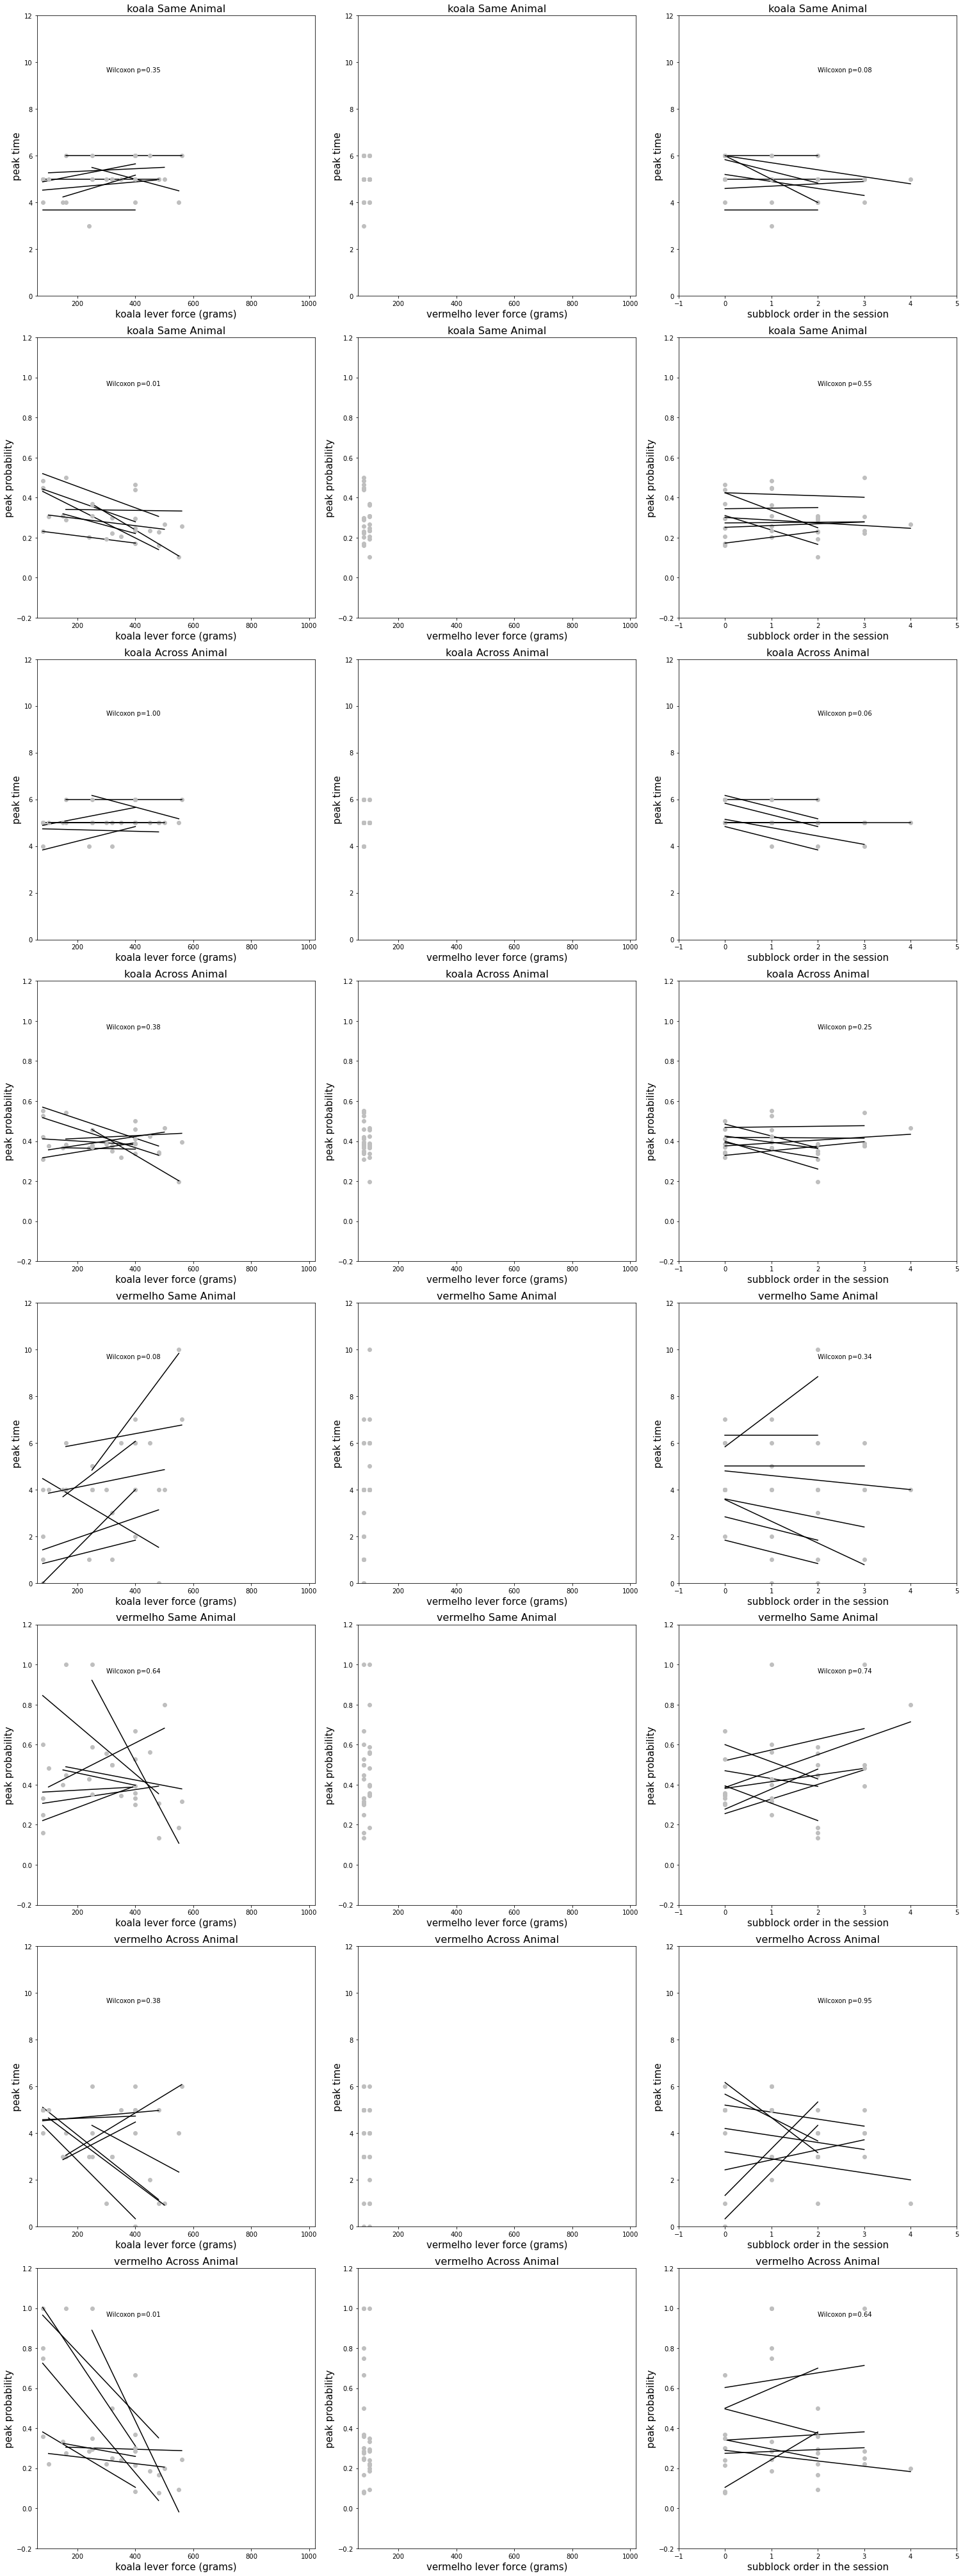

In [348]:
# load the data for plot
mergetempRos = 0
doBhvitv_timebin = 0

temp_resolu = 1 # temporal resolution - 1s

data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'

# load the gaze distribution data
if not mergetempRos:
    if doBhvitv_timebin:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes =pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
    else:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes=pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
else:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes=pickle.load(f) 
    #
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_shuffle_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_shuffle_all=pickle.load(f)


# initialize for plot
animals_forplot = [animal1_fixedorder[0],animal2_fixedorder[0]]
nanimals_forplot = np.shape(animals_forplot)[0]

nplottypes = 2 # SameAnimal or AcroAnimal

fig, axs = plt.subplots(nanimals_forplot*nplottypes*2,3)
fig.set_figheight(7*nanimals_forplot*nplottypes*2)
fig.set_figwidth(7*3)

# for plot each day separately
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
#
trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

#
for ianimal in np.arange(0,nanimals_forplot,1):
    
    animal_forplot = animals_forplot[ianimal]
    
    # same animal vs across animal
    for iplottype in np.arange(0,nplottypes,1):
            
        if iplottype == 0:
            target_mean_all = SameAnimal_gazeDist_mean_all
            target_shuffle_all = SameAnimal_gazeDist_shuffle_all
            #
            plottype = 'Same Animal'
        #    
        elif iplottype == 1:
            target_mean_all = AcroAnimal_gazeDist_mean_all
            target_shuffle_all = AcroAnimal_gazeDist_shuffle_all
            #
            plottype = 'Across Animal'
    
        # initialize the peak time and peak distribution array for plot
        ndatalist = np.shape(force1_all_dates)[0]
        peaktime_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        peakdist_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        #
        slopes1_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        slopes2_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        slopes3_all_dates = np.ones(np.shape(force1_all_dates))*np.nan

        # prepare the data for distribution peak time and peak distribution
        for idatalist in np.arange(0,ndatalist,1):
            
            iforce1 = int(force1_all_dates[idatalist])
            iforce2 = int(force2_all_dates[idatalist])
            idate = trialdates_all_dates[idatalist]
            
            try:
                peaktime_all_dates[idatalist] = np.nanargmax(target_mean_all[animal_forplot][idate][str(iforce1)+'&'+str(iforce2)])
                peakdist_all_dates[idatalist] = np.nanmax(target_mean_all[animal_forplot][idate][str(iforce1)+'&'+str(iforce2)])
            except:
                continue
                
        # plot         
        # peak time or peak distibution
        for ipeaktimedist in np.arange(0,2,1):
        
            isubplotID = int(str(ianimal*100+iplottype*10+ipeaktimedist),2)
            
            # plot, against force1, force2 and block order, separate for each date
            # plot each day separately
            for idate in np.arange(0,ntrialdates_forplot,1):
                trialdate_idate = trialdates_all_dates_unique[idate]

                ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)

                if np.sum(ind_idate)>0:
                    
                    if ipeaktimedist == 0:
                        yyy = peaktime_all_dates[ind_forplot]
                        ylimmin = 0
                        ylimmax = 12
                        ylabelname = 'peak time'
                    elif ipeaktimedist == 1:
                        yyy = peakdist_all_dates[ind_forplot]
                        ylimmin = -0.2
                        ylimmax = 1.2
                        ylabelname = 'peak probability'
                    yyy = yyy[ind_idate]
                        
                    # subplot 1
                    xxx = force1_all_dates[ind_forplot]
                    xxx = xxx[ind_idate]
                    #
                    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
                    slopes1_all_dates[idate] = slope
                    axs[isubplotID,0].plot(xxx,yyy,'o',color = '0.75')
                    axs[isubplotID,0].plot(np.array([xxx.min(),xxx.max()]),
                                           np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
                    axs[isubplotID,0].set_xlabel(animal1_fixedorder[0]+' lever force (grams)',fontsize=15)
                    axs[isubplotID,0].set_ylabel(ylabelname,fontsize=15)
                    axs[isubplotID,0].set_ylim(ylimmin,ylimmax)
                    axs[isubplotID,0].set_title(animal_forplot+' '+plottype, fontsize=16)
                    axs[isubplotID,0].set_xlim(60,1020)
                           
                    # subplot 2
                    xxx = force2_all_dates[ind_forplot]
                    xxx = xxx[ind_idate]
                    #
                    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
                    slopes2_all_dates[idate] = slope
                    axs[isubplotID,1].plot(xxx,yyy,'o',color = '0.75')
                    axs[isubplotID,1].plot(np.array([xxx.min(),xxx.max()]),
                                           np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
                    axs[isubplotID,1].set_xlabel(animal2_fixedorder[0]+' lever force (grams)',fontsize=15)
                    axs[isubplotID,1].set_ylabel(ylabelname,fontsize=15)
                    axs[isubplotID,1].set_ylim(ylimmin,ylimmax)
                    axs[isubplotID,1].set_title(animal_forplot+' '+plottype, fontsize=16)
                    axs[isubplotID,1].set_xlim(60,1020)

                    # subplot 3
                    xxx = subblockID_all_dates[ind_forplot]
                    xxx = xxx[ind_idate]
                    #
                    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
                    slopes3_all_dates[idate] = slope
                    axs[isubplotID,2].plot(xxx,yyy,'o',color = '0.75')
                    axs[isubplotID,2].plot(np.array([xxx.min(),xxx.max()]),
                                           np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
                    axs[isubplotID,2].set_xlabel('subblock order in the session',fontsize=15)
                    axs[isubplotID,2].set_ylabel(ylabelname,fontsize=15)
                    axs[isubplotID,2].set_ylim(ylimmin,ylimmax)
                    axs[isubplotID,2].set_title(animal_forplot+' '+plottype, fontsize=16)
                    axs[isubplotID,2].set_xlim(-1,5)
           
            # add the statitics for the slope
            for iplot in np.arange(0,3,1):
                try:
                    # subplot 1
                    if iplot == 0:
                        pp = st.wilcoxon(slopes1_all_dates[~np.isnan(slopes1_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue
                        axs[isubplotID,0].text(300,ylimmax*0.8,'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
                    # subplot 2
                    elif iplot == 1:
                        pp = st.wilcoxon(slopes2_all_dates[~np.isnan(slopes2_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue    
                        axs[isubplotID,1].text(300,ylimmax*0.8,'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
                    # subplot 3
                    elif iplot == 2:
                        pp = st.wilcoxon(slopes3_all_dates[~np.isnan(slopes3_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue
                        axs[isubplotID,2].text(2.0,ylimmax*0.8,'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
                except:
                    continue

fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"forcelevel_gazeDistAroundPullpeakProbTime_separatedays_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pdf')

#### plot the  distribution of gaze before and after pulls
#### pull <-> pull; within animal gaze -> pull; across animal pull -> gaze; within animal pull -> gaze
#### regress against subblock ID first, and then plot the residual against force1 and force2 and separate each day (session);
#### regress (>2) or connect (2) trial types in each session

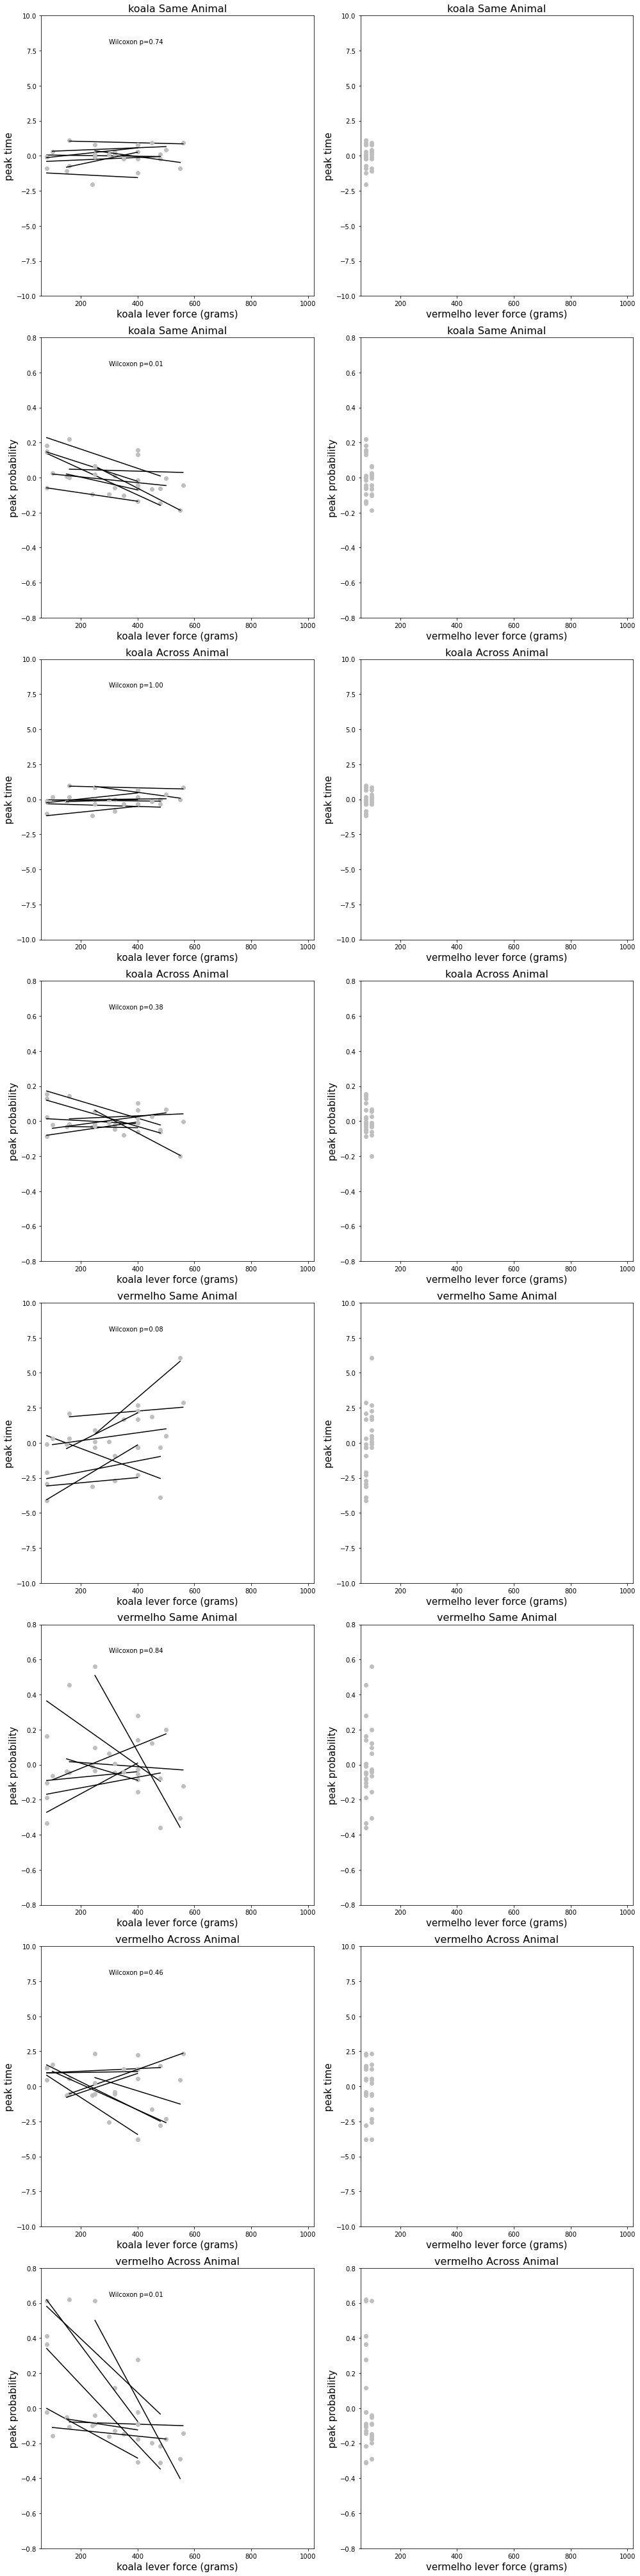

In [349]:
# load the data for plot
mergetempRos = 0
doBhvitv_timebin = 0

temp_resolu = 1 # temporal resolution - 1s

data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'

# load the gaze distribution data
if not mergetempRos:
    if doBhvitv_timebin:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes =pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
    else:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes=pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
else:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes=pickle.load(f) 
    #
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_shuffle_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_shuffle_all=pickle.load(f)


# initialize for plot
animals_forplot = [animal1_fixedorder[0],animal2_fixedorder[0]]
nanimals_forplot = np.shape(animals_forplot)[0]

nplottypes = 2 # SameAnimal or AcroAnimal

fig, axs = plt.subplots(nanimals_forplot*nplottypes*2,2)
fig.set_figheight(7*nanimals_forplot*nplottypes*2)
fig.set_figwidth(7*2)

# for plot each day separately
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
#
trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

#
for ianimal in np.arange(0,nanimals_forplot,1):
    
    animal_forplot = animals_forplot[ianimal]
    
    # same animal vs across animal
    for iplottype in np.arange(0,nplottypes,1):
            
        if iplottype == 0:
            target_mean_all = SameAnimal_gazeDist_mean_all
            target_shuffle_all = SameAnimal_gazeDist_shuffle_all
            #
            plottype = 'Same Animal'
        #    
        elif iplottype == 1:
            target_mean_all = AcroAnimal_gazeDist_mean_all
            target_shuffle_all = AcroAnimal_gazeDist_shuffle_all
            #
            plottype = 'Across Animal'
    
        # initialize the peak time and peak distribution array for plot
        ndatalist = np.shape(force1_all_dates)[0]
        peaktime_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        peakdist_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        #
        slopes1_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        slopes2_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        slopes3_all_dates = np.ones(np.shape(force1_all_dates))*np.nan

        # prepare the data for distribution peak time and peak distribution
        for idatalist in np.arange(0,ndatalist,1):
            
            iforce1 = int(force1_all_dates[idatalist])
            iforce2 = int(force2_all_dates[idatalist])
            idate = trialdates_all_dates[idatalist]
            
            try:
                peaktime_all_dates[idatalist] = np.nanargmax(target_mean_all[animal_forplot][idate][str(iforce1)+'&'+str(iforce2)])
                peakdist_all_dates[idatalist] = np.nanmax(target_mean_all[animal_forplot][idate][str(iforce1)+'&'+str(iforce2)])
            except:
                continue
        
        # plot         
        # peak time or peak distibution
        for ipeaktimedist in np.arange(0,2,1):
        
            isubplotID = int(str(ianimal*100+iplottype*10+ipeaktimedist),2)
            
            if ipeaktimedist == 0:
                yyy = peaktime_all_dates[ind_forplot]
                ylimmin = -10
                ylimmax = 10
                ylabelname = 'peak time'
            elif ipeaktimedist == 1:
                yyy = peakdist_all_dates[ind_forplot]
                ylimmin = -0.8
                ylimmax = 0.8
                ylabelname = 'peak probability'
            
            # regress again subblock ID first
            xxx = subblockID_all_dates[ind_forplot]
            slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
            # 
            yyy_res = yyy - (xxx*slope+intercept)
            
            # plot, against force1, force2 with the subblock ID regressed residue
            # plot each day separately
            for idate in np.arange(0,ntrialdates_forplot,1):
                trialdate_idate = trialdates_all_dates_unique[idate]

                ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)

                if np.sum(ind_idate)>0:
                    
                    yyy_idate = yyy_res[ind_idate]
                        
                    # subplot 1
                    xxx = force1_all_dates[ind_forplot]
                    xxx = xxx[ind_idate]
                    #
                    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy_idate)
                    slopes1_all_dates[idate] = slope
                    axs[isubplotID,0].plot(xxx,yyy_idate,'o',color = '0.75')
                    axs[isubplotID,0].plot(np.array([xxx.min(),xxx.max()]),
                                           np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
                    axs[isubplotID,0].set_xlabel(animal1_fixedorder[0]+' lever force (grams)',fontsize=15)
                    axs[isubplotID,0].set_ylabel(ylabelname,fontsize=15)
                    axs[isubplotID,0].set_ylim(ylimmin,ylimmax)
                    axs[isubplotID,0].set_title(animal_forplot+' '+plottype, fontsize=16)
                    axs[isubplotID,0].set_xlim(60,1020)
                           
                    # subplot 2
                    xxx = force2_all_dates[ind_forplot]
                    xxx = xxx[ind_idate]
                    #
                    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy_idate)
                    slopes2_all_dates[idate] = slope
                    axs[isubplotID,1].plot(xxx,yyy_idate,'o',color = '0.75')
                    axs[isubplotID,1].plot(np.array([xxx.min(),xxx.max()]),
                                           np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
                    axs[isubplotID,1].set_xlabel(animal2_fixedorder[0]+' lever force (grams)',fontsize=15)
                    axs[isubplotID,1].set_ylabel(ylabelname,fontsize=15)
                    axs[isubplotID,1].set_ylim(ylimmin,ylimmax)
                    axs[isubplotID,1].set_title(animal_forplot+' '+plottype, fontsize=16)
                    axs[isubplotID,1].set_xlim(60,1020)

                   
           
            # add the statitics for the slope
            for iplot in np.arange(0,3,1):
                try:
                    # subplot 1
                    if iplot == 0:
                        pp = st.wilcoxon(slopes1_all_dates[~np.isnan(slopes1_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue
                        axs[isubplotID,0].text(300,ylimmax*0.8,'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
                    # subplot 2
                    elif iplot == 1:
                        pp = st.wilcoxon(slopes2_all_dates[~np.isnan(slopes2_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue    
                        axs[isubplotID,1].text(300,ylimmax*0.8,'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
                except:
                    continue

fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"subblockIDregressedResidual_forcelevel_gazeDistAroundPullpeakProbTime_separatedays_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pdf')

#### normalize force1 force2 and subblockID for each day (session); then do multi-variable regression

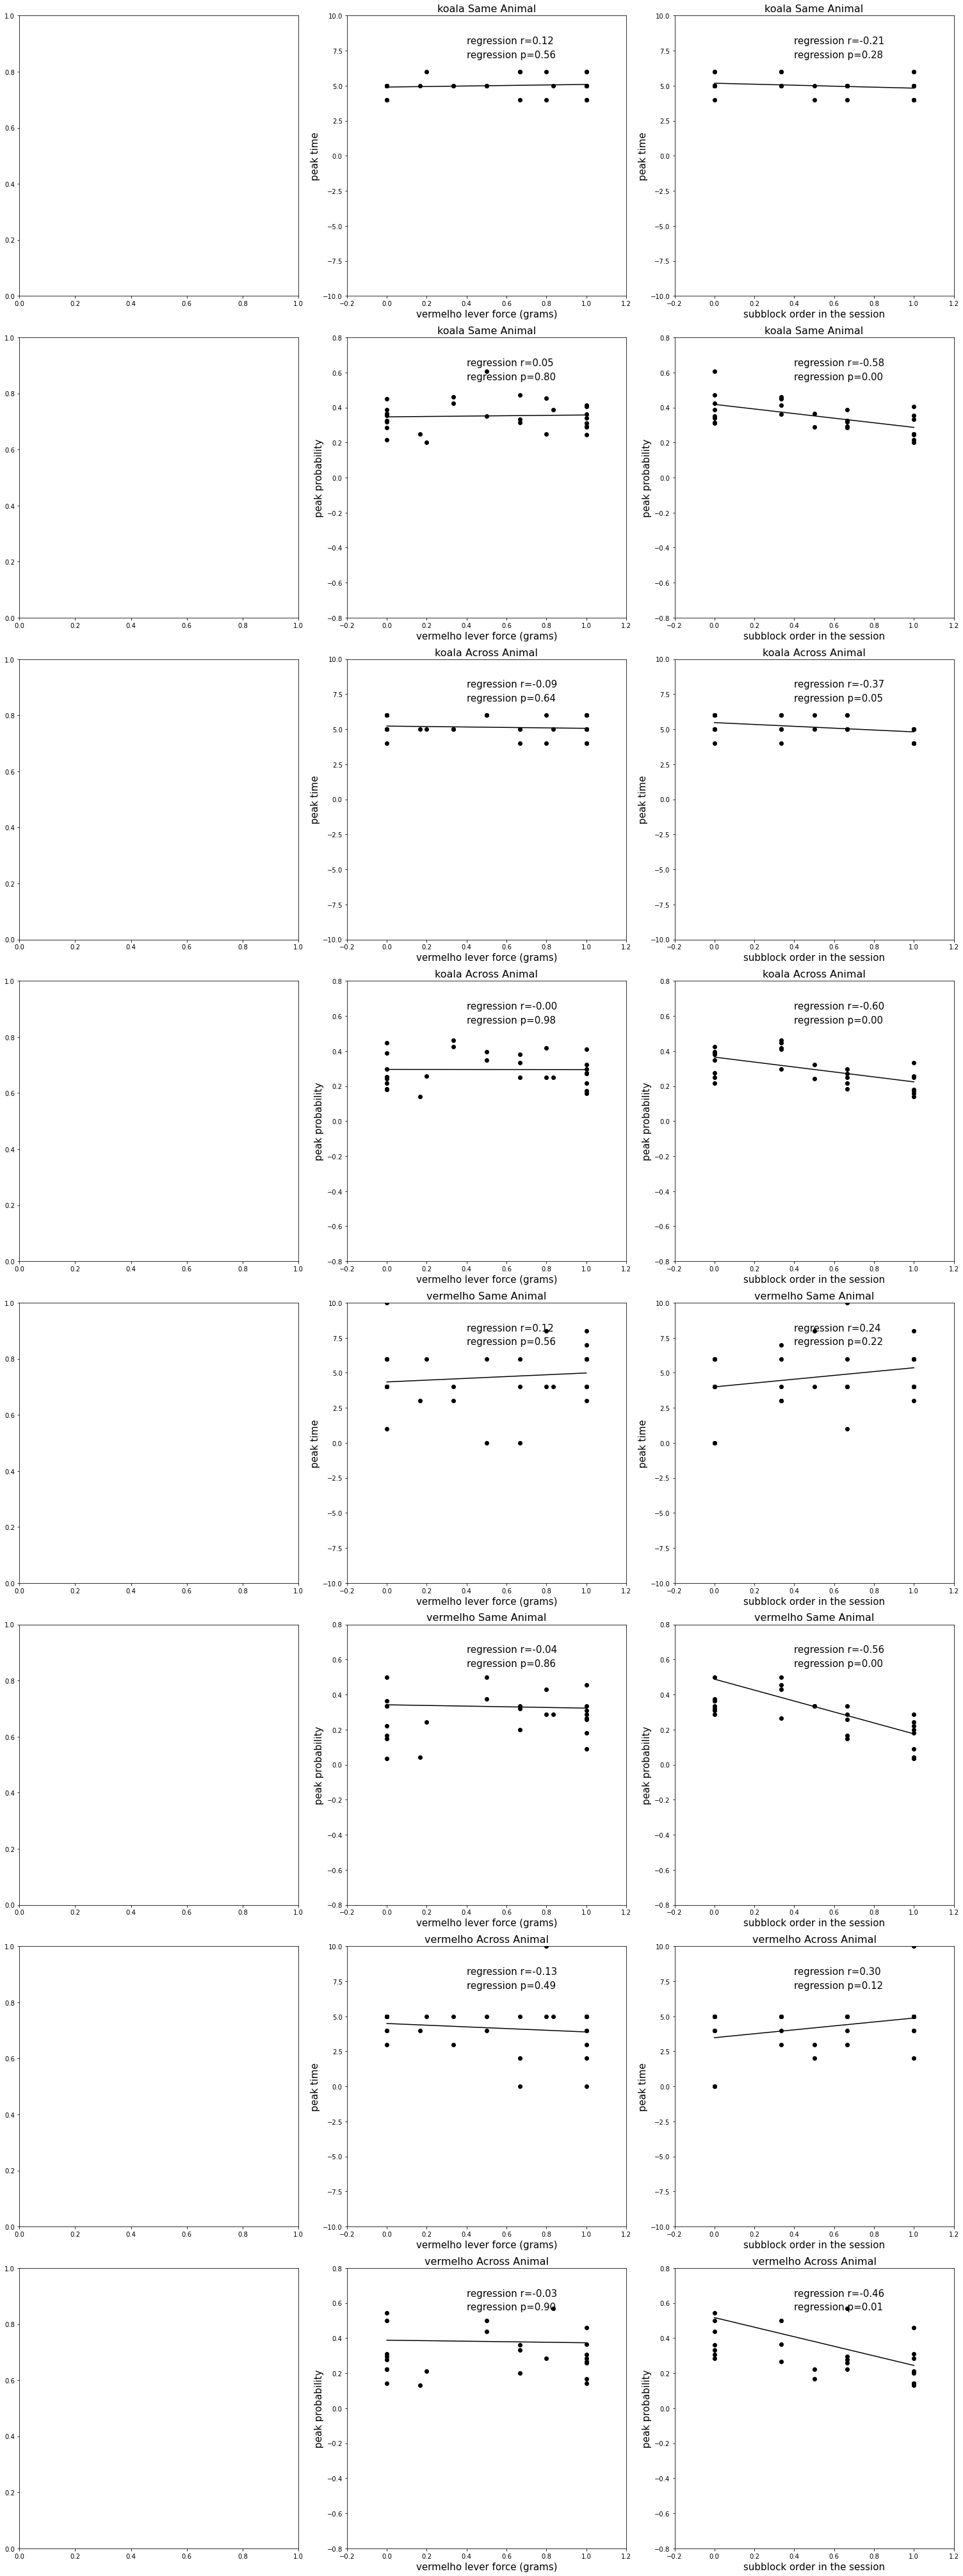

In [335]:
# load the data for plot
mergetempRos = 0
doBhvitv_timebin = 0

temp_resolu = 1 # temporal resolution - 1s

data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'

# load the gaze distribution data
if not mergetempRos:
    if doBhvitv_timebin:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes =pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
    else:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes=pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
else:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes=pickle.load(f) 
    #
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_shuffle_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_shuffle_all=pickle.load(f)


# initialize for plot
animals_forplot = [animal1_fixedorder[0],animal2_fixedorder[0]]
nanimals_forplot = np.shape(animals_forplot)[0]

nplottypes = 2 # SameAnimal or AcroAnimal

fig, axs = plt.subplots(nanimals_forplot*nplottypes*2,3)
fig.set_figheight(7*nanimals_forplot*nplottypes*2)
fig.set_figwidth(7*3)

# for plot each day separately
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
#
trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

#
for ianimal in np.arange(0,nanimals_forplot,1):
    
    animal_forplot = animals_forplot[ianimal]
    
    # same animal vs across animal
    for iplottype in np.arange(0,nplottypes,1):
            
        if iplottype == 0:
            target_mean_all = SameAnimal_gazeDist_mean_all
            target_shuffle_all = SameAnimal_gazeDist_shuffle_all
            #
            plottype = 'Same Animal'
        #    
        elif iplottype == 1:
            target_mean_all = AcroAnimal_gazeDist_mean_all
            target_shuffle_all = AcroAnimal_gazeDist_shuffle_all
            #
            plottype = 'Across Animal'
    
        # initialize the peak time and peak distribution array for plot
        ndatalist = np.shape(force1_all_dates)[0]
        peaktime_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        peakdist_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        #
        slopes1_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        slopes2_all_dates = np.ones(np.shape(force1_all_dates))*np.nan
        slopes3_all_dates = np.ones(np.shape(force1_all_dates))*np.nan

        # prepare the data for distribution peak time and peak distribution
        for idatalist in np.arange(0,ndatalist,1):
            
            iforce1 = int(force1_all_dates[idatalist])
            iforce2 = int(force2_all_dates[idatalist])
            idate = trialdates_all_dates[idatalist]
            
            try:
                peaktime_all_dates[idatalist] = np.nanargmax(target_mean_all[animal_forplot][idate][str(iforce1)+'&'+str(iforce2)])
                peakdist_all_dates[idatalist] = np.nanmax(target_mean_all[animal_forplot][idate][str(iforce1)+'&'+str(iforce2)])
            except:
                continue
        
        # plot         
        # peak time or peak distibution
        for ipeaktimedist in np.arange(0,2,1):
        
            isubplotID = int(str(ianimal*100+iplottype*10+ipeaktimedist),2)
            
            if ipeaktimedist == 0:
                yyy = peaktime_all_dates[ind_forplot]
                ylimmin = -10
                ylimmax = 10
                ylabelname = 'peak time'
            elif ipeaktimedist == 1:
                yyy = peakdist_all_dates[ind_forplot]
                ylimmin = -0.8
                ylimmax = 0.8
                ylabelname = 'peak probability'
            
            xxx1 = force1_all_dates[ind_forplot]
            xxx2 = force2_all_dates[ind_forplot]
            xxx3 = subblockID_all_dates[ind_forplot]

            yyy_norm = yyy
            xxx1_norm = xxx1
            xxx2_norm = xxx2
            xxx3_norm = xxx3
            
            # normalize the variables separately for each day
            for idate in np.arange(0,ntrialdates_forplot,1):
                trialdate_idate = trialdates_all_dates_unique[idate]

                ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)

                yyy_idate = yyy[ind_idate]
                xxx1_idate = xxx1[ind_idate]
                xxx2_idate = xxx2[ind_idate]
                xxx3_idate = xxx3[ind_idate]
                #
                xxx1_norm[ind_idate]=(xxx1_idate-np.nanmin(xxx1_idate))/(np.nanmax(xxx1_idate)-np.nanmin(xxx1_idate))
                xxx2_norm[ind_idate]=(xxx2_idate-np.nanmin(xxx2_idate))/(np.nanmax(xxx2_idate)-np.nanmin(xxx2_idate))
                xxx3_norm[ind_idate]=(xxx3_idate-np.nanmin(xxx3_idate))/(np.nanmax(xxx3_idate)-np.nanmin(xxx3_idate))
                   
           
            # plot three kinds of x variables
            xlabels_all = [animal1_fixedorder[0]+' lever force (grams)',
                           animal2_fixedorder[0]+' lever force (grams)',
                           'subblock order in the session',
                          ]

            for isubplot in np.arange(0,3,1): 

                if isubplot == 0:
                    xxx_iplot = xxx1_norm
                elif isubplot == 1:
                    xxx_iplot = xxx2_norm
                elif isubplot == 2:
                    xxx_iplot = xxx3_norm

                try:
                    # subplot 1,2,3
                    slope, intercept, rr, pp, std_err = st.linregress(xxx_iplot[~np.isnan(xxx_iplot)], yyy_norm[[~np.isnan(xxx_iplot)]])
                    axs[isubplotID,isubplot].text(0.4,ylimmax*0.8,'regression r='+"{:.2f}".format(rr),fontsize=15)
                    axs[isubplotID,isubplot].text(0.4,ylimmax*0.7,'regression p='+"{:.2f}".format(pp),fontsize=15)
                    axs[isubplotID,isubplot].plot(xxx_iplot,yyy_norm,'ko')
                    axs[isubplotID,isubplot].plot(np.array([np.nanmin(xxx_iplot),np.nanmax(xxx_iplot)]),
                                             np.array([np.nanmin(xxx_iplot),np.nanmax(xxx_iplot)])*slope+intercept,'k-')
                    axs[isubplotID,isubplot].set_xlabel(xlabels_all[isubplot],fontsize=15)
                    axs[isubplotID,isubplot].set_ylabel(ylabelname,fontsize=15)
                    axs[isubplotID,isubplot].set_title(animal_forplot+' '+plottype, fontsize=16)
                    axs[isubplotID,isubplot].set_ylim(ylimmin,ylimmax)
                    axs[isubplotID,isubplot].set_xlim(-0.2,1.2)
    
                except:
                    continue
        
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"forcelevel_successfulrate_pullnumbers_normalized_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pdf')
    
    

#### for each day separate three subblocks and then average the pull aligned gaze distribution

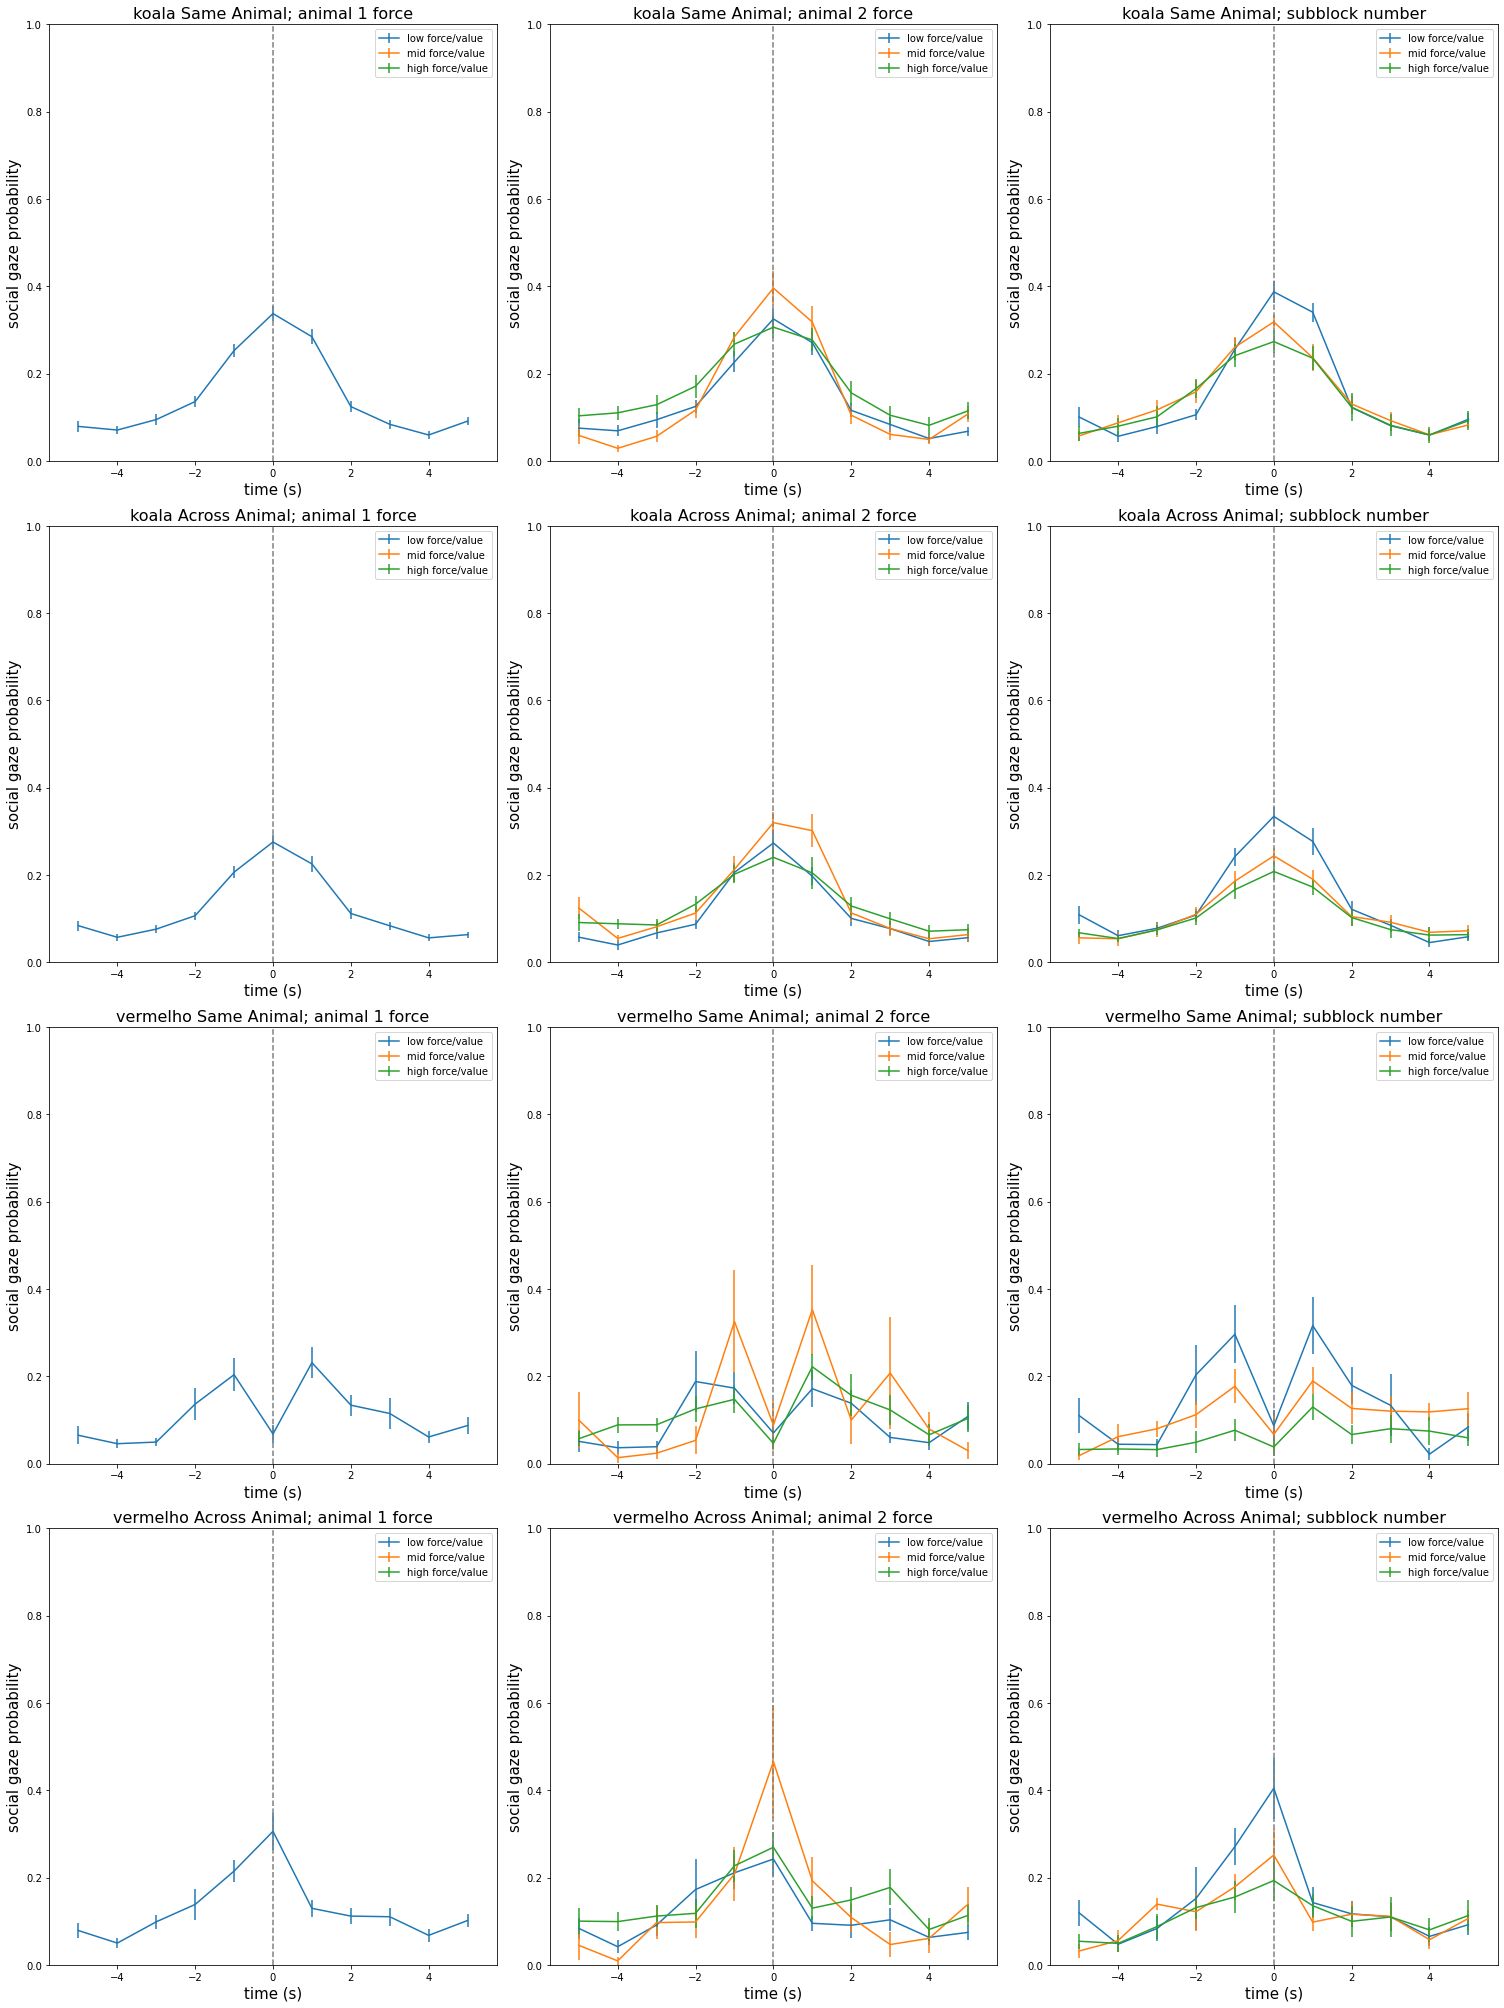

In [342]:
# load the data for plot
mergetempRos = 0
doBhvitv_timebin = 0

temp_resolu = 1 # temporal resolution - 1s

data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'

# load the gaze distribution data
if not mergetempRos:
    if doBhvitv_timebin:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes =pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
    else:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes=pickle.load(f)
        #
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_mean_all=pickle.load(f)
        with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            SameAnimal_gazeDist_shuffle_all=pickle.load(f)
        with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            AcroAnimal_gazeDist_shuffle_all=pickle.load(f)
else:
    with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        DBN_input_data_alltypes=pickle.load(f) 
    #
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_mean_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_mean_all=pickle.load(f)
    with open(data_saved_subfolder+'/SameAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        SameAnimal_gazeDist_shuffle_all=pickle.load(f)
    with open(data_saved_subfolder+'/AcroAnimal_gazeDist_shuffle_all_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_mergeTempsReSo.pkl', 'rb') as f:
        AcroAnimal_gazeDist_shuffle_all=pickle.load(f)


# initialize for plot
animals_forplot = [animal1_fixedorder[0],animal2_fixedorder[0]]
nanimals_forplot = np.shape(animals_forplot)[0]

nplottypes = 2 # SameAnimal or AcroAnimal

fig, axs = plt.subplots(nanimals_forplot*nplottypes,3)
fig.set_figheight(7*nanimals_forplot*nplottypes)
fig.set_figwidth(7*3)

# for plot each day separately
trialdates_all_dates_unique = np.unique(trialdates_all_dates)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

#
for ianimal in np.arange(0,nanimals_forplot,1):
    
    animal_forplot = animals_forplot[ianimal]
    
    # same animal vs across animal
    for iplottype in np.arange(0,nplottypes,1):
            
        isubplotID = int(str(ianimal*10+iplottype),2)
            
        if iplottype == 0:
            target_mean_all = SameAnimal_gazeDist_mean_all
            target_shuffle_all = SameAnimal_gazeDist_shuffle_all
            #
            plottype = 'Same Animal'
        #    
        elif iplottype == 1:
            target_mean_all = AcroAnimal_gazeDist_mean_all
            target_shuffle_all = AcroAnimal_gazeDist_shuffle_all
            #
            plottype = 'Across Animal'
    
        # for each day, separate the blocked into three categories, for three different variables - force1, force2, subblockID
        for ixplottype in np.arange(0,3,1):
            
            if ixplottype == 0:
                xplotvalue_all_dates = force1_all_dates
                xplotname = 'animal 1 force'
            elif ixplottype == 1:
                xplotvalue_all_dates = force2_all_dates
                xplotname = 'animal 2 force'
            elif ixplottype == 2:
                xplotvalue_all_dates = subblockID_all_dates
                xplotname = 'subblock number'
            
            # initialize, across days, separate based on the xplotvalue's quantiles
            distarget_mean_all_q1 = np.zeros((0,))
            distarget_mean_all_q2 = np.zeros((0,))
            distarget_mean_all_q3 = np.zeros((0,))
            distarget_shuffle_all_q1 = np.zeros((0,))
            distarget_shuffle_all_q2 = np.zeros((0,))
            distarget_shuffle_all_q3 = np.zeros((0,))
                    
            for idatenum in np.arange(0,ntrialdates_forplot,1):

                idate = trialdates_all_dates_unique[idatenum]

                ind_idate = np.isin(trialdates_all_dates,idate)    

                xplotvalue_idate = xplotvalue_all_dates[ind_idate]

                disttarget_mean_idate = np.vstack(list(target_mean_all[animal_forplot][idate].values()))
                disttarget_shuffle_idate = np.vstack(list(target_mean_all[animal_forplot][idate].values()))

                # separate the three quantiles
                ind_q1 = xplotvalue_idate<=np.quantile(xplotvalue_idate,1/3)
                ind_q2 = (xplotvalue_idate<=np.quantile(xplotvalue_idate,2/3))&(xplotvalue_idate>np.quantile(xplotvalue_idate,1/3))
                ind_q3 = (xplotvalue_idate<=np.quantile(xplotvalue_idate,3/3))&(xplotvalue_idate>np.quantile(xplotvalue_idate,2/3))
                #
                if np.shape(distarget_mean_all_q1)[0]==0:
                    distarget_mean_all_q1 = disttarget_mean_idate[ind_q1]
                    distarget_mean_all_q2 = disttarget_mean_idate[ind_q2]
                    distarget_mean_all_q3 = disttarget_mean_idate[ind_q3]
                    distarget_shuffle_all_q1 = disttarget_shuffle_idate[ind_q1]
                    distarget_shuffle_all_q2 = disttarget_shuffle_idate[ind_q2]
                    distarget_shuffle_all_q3 = disttarget_shuffle_idate[ind_q3]
                else:
                    distarget_mean_all_q1 = np.vstack((distarget_mean_all_q1,disttarget_mean_idate[ind_q1]))
                    distarget_mean_all_q2 = np.vstack((distarget_mean_all_q2,disttarget_mean_idate[ind_q2]))
                    distarget_mean_all_q3 = np.vstack((distarget_mean_all_q3,disttarget_mean_idate[ind_q3]))
                    distarget_shuffle_all_q1 = np.vstack((distarget_shuffle_all_q1,disttarget_shuffle_idate[ind_q1]))
                    distarget_shuffle_all_q2 = np.vstack((distarget_shuffle_all_q2,disttarget_shuffle_idate[ind_q2]))
                    distarget_shuffle_all_q3 = np.vstack((distarget_shuffle_all_q3,disttarget_shuffle_idate[ind_q3]))
        
            # for plot
            xxx = np.arange(-dist_twin_range,dist_twin_range+1,1)
            #
            yyy_q1 = np.nanmean(distarget_mean_all_q1,axis=0) 
            yyy_q1_se = np.nanstd(distarget_mean_all_q1,axis=0)/np.sqrt(np.shape(distarget_mean_all_q1)[0])
            yyy_q2 = np.nanmean(distarget_mean_all_q2,axis=0) 
            yyy_q2_se = np.nanstd(distarget_mean_all_q2,axis=0)/np.sqrt(np.shape(distarget_mean_all_q2)[0])
            yyy_q3 = np.nanmean(distarget_mean_all_q3,axis=0) 
            yyy_q3_se = np.nanstd(distarget_mean_all_q3,axis=0)/np.sqrt(np.shape(distarget_mean_all_q3)[0])
            #
            axs[isubplotID,ixplottype].errorbar(xxx,yyy_q1,yyy_q1_se,label='low force/value')
            axs[isubplotID,ixplottype].errorbar(xxx,yyy_q2,yyy_q2_se,label='mid force/value')
            axs[isubplotID,ixplottype].errorbar(xxx,yyy_q3,yyy_q3_se,label='high force/value')
            axs[isubplotID,ixplottype].plot([0,0],[0,1],'--',color='0.5')
            axs[isubplotID,ixplottype].set_xlim(-dist_twin_range-0.75,dist_twin_range+0.75)
            axs[isubplotID,ixplottype].set_ylim(0,1)
            axs[isubplotID,ixplottype].set_xlabel('time (s)',fontsize=15)
            axs[isubplotID,ixplottype].set_ylabel('social gaze probability',fontsize=15)
            axs[isubplotID,ixplottype].legend()   
            axs[isubplotID,ixplottype].set_title(animal_forplot+' '+plottype+'; '+xplotname,fontsize=16) 
            
        
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"gazeProb_pull_aligned_forceQuantiles_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'_'+str(temp_resolu)+'sReSo.pdf')
    
    

In [337]:
np.shape(distarget_mean_all_q1)[0]

13

In [338]:
xplotvalue_idate

array([0., 1., 2., 3.])

In [339]:
disttarget_mean_idate

array([[0.33333333, 0.        , 0.33333333, 0.        , 0.33333333,
        0.33333333, 0.        , 0.        , 0.33333333, 0.        ,
        0.        ],
       [0.06666667, 0.06666667, 0.13333333, 0.13333333, 0.26666667,
        0.2       , 0.13333333, 0.2       , 0.26666667, 0.13333333,
        0.2       ],
       [0.05555556, 0.11111111, 0.11111111, 0.11111111, 0.16666667,
        0.27777778, 0.05555556, 0.05555556, 0.11111111, 0.11111111,
        0.16666667],
       [0.        , 0.        , 0.        , 0.14285714, 0.14285714,
        0.14285714, 0.14285714, 0.        , 0.        , 0.14285714,
        0.28571429]])

### run the DBN model on the combined session data set

#### a test run

In [340]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 1 # number of random starting points/graphs
nbootstraps = 1

if 0:

    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

                
        # only try three sample sizes
        #- minimal row number (require data downsample) and maximal row number (require data upsample)
        #- full row number of each session
        if minmaxfullSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            #samplingsizes = [min_samplesize,max_samplesize,np.nan]
            #samplingsizes_name = ['min_row_number','max_row_number','full_row_number']
            samplingsizes = [np.nan]
            samplingsizes_name = ['full_row_number']
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        # for jj in np.arange(0,nsamplings,1):
        for jj in np.arange(0,1,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_alltypes = dict.fromkeys(dates_list, [])
            DAGs_scores_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(dates_list, [])

            weighted_graphs_alltypes = dict.fromkeys(dates_list, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(dates_list, [])
            sig_edges_alltypes = dict.fromkeys(dates_list, [])

            # different individual sessions
            ndates = np.shape(dates_list)[0]
            for idate in np.arange(0,ndates,1):
                date_tgt = dates_list[idate]
                
                if samplingsizes_name[jj]=='full_row_number':
                    isamplingsize = np.shape(DBN_input_data_alltypes[date_tgt])[0]

                try:
                    bhv_df_all = DBN_input_data_alltypes[date_tgt]

                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[date_tgt] = DAGs_randstart 
                    DAGs_shuffle_alltypes[date_tgt] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[date_tgt] = score_randstart
                    DAGs_shuffle_scores_alltypes[date_tgt] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[date_tgt],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[date_tgt],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[date_tgt] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[date_tgt] = weighted_graphs_shuffled
                    sig_edges_alltypes[date_tgt] = sig_edges
                    
                except:
                    DAGs_alltypes[date_tgt] = [] 
                    DAGs_shuffle_alltypes[date_tgt] = []

                    DAGs_scores_alltypes[date_tgt] = []
                    DAGs_shuffle_scores_alltypes[date_tgt] = []

                    weighted_graphs_alltypes[date_tgt] = []
                    weighted_graphs_shuffled_alltypes[date_tgt] = []
                    sig_edges_alltypes[date_tgt] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

    print(weighted_graphs_diffTempRo_diffSampSize)
            
   

#### run on the entire population

In [341]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session

moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 100 # number of random starting points/graphs
nbootstraps = 95

try:
    # dumpy
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    if minmaxfullSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

except:
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = np.arange(1100,3000,100)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    totalsess_time = 600 # total session time in s
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not mergetempRos:
            if doBhvitv_timebin:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'bhvItvTempReSo.pkl', 'rb') as f:
                    DBN_input_data_allsessions = pickle.load(f)
            else:
                with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                    DBN_input_data_allsessions = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alls = pickle.load(f)

                
        # only try three sample sizes
        #- minimal row number (require data downsample) and maximal row number (require data upsample)
        #- full row number of each session
        if minmaxfullSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            # samplingsizes = [min_samplesize,max_samplesize,np.nan]
            # samplingsizes_name = ['min_row_number','max_row_number','full_row_number']   
            samplingsizes = [np.nan]
            samplingsizes_name = ['full_row_number']
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        for jj in np.arange(0,nsamplings,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_alltypes = dict.fromkeys(dates_list, [])
            DAGs_scores_alltypes = dict.fromkeys(dates_list, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(dates_list, [])

            weighted_graphs_alltypes = dict.fromkeys(dates_list, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(dates_list, [])
            sig_edges_alltypes = dict.fromkeys(dates_list, [])

            # different individual sessions
            ndates = np.shape(dates_list)[0]
            for idate in np.arange(0,ndates,1):
                date_tgt = dates_list[idate]
                
                if samplingsizes_name[jj]=='full_row_number':
                    isamplingsize = np.shape(DBN_input_data_allsessions[date_tgt])[0]

                try:
                    bhv_df_all = DBN_input_data_alltypes[date_tgt]


                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[date_tgt] = DAGs_randstart 
                    DAGs_shuffle_alltypes[date_tgt] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[date_tgt] = score_randstart
                    DAGs_shuffle_scores_alltypes[date_tgt] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[date_tgt],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[date_tgt],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[date_tgt] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[date_tgt] = weighted_graphs_shuffled
                    sig_edges_alltypes[date_tgt] = sig_edges
                    
                except:
                    DAGs_alltypes[date_tgt] = [] 
                    DAGs_shuffle_alltypes[date_tgt] = []

                    DAGs_scores_alltypes[date_tgt] = []
                    DAGs_shuffle_scores_alltypes[date_tgt] = []

                    weighted_graphs_alltypes[date_tgt] = []
                    weighted_graphs_shuffled_alltypes[date_tgt] = []
                    sig_edges_alltypes[date_tgt] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
    # save data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:  
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)
    elif minmaxfullSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_minmaxfullSampSize.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)        
    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_forceManipulation_task_data_saved/data_saved_singlecam_wholebody_allsessions_bestsessions_3lags/camera-2/koalavermelho//DBN_input_data_alltypes_koalavermelho_1sReSo.pkl'

### plot the edges over time (session)
#### mean edge weights of selected edges

In [ ]:
# 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting



#
# sort the data based on task type and dates
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
dates_list_sorted = np.array(dates_list)[sorting_df.index]
ndates_sorted = np.shape(dates_list_sorted)[0]

In [ ]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
elif minmaxfullSampSize:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]   

# 1s time lag
edges_target_names = [['1slag_pull2_pull1','1slag_pull1_pull2'],
                      ['1slag_gaze1_pull1','1slag_gaze2_pull2'],
                      ['1slag_pull2_gaze1','1slag_pull1_gaze2'],]
fromNodesIDs = [[ 9, 8],
                [10,11],
                [ 9, 8],]
toNodesIDs = [[0,1],
              [0,1],
              [2,3]]

n_edges = np.shape(np.array(edges_target_names).flatten())[0]

# figure initiate
fig, axs = plt.subplots(int(np.ceil(n_edges/2)),2)
fig.set_figheight(5*np.ceil(n_edges/2))
fig.set_figwidth(10*2)

#
for i_edge in np.arange(0,n_edges,1):
    #
    edgeweight_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_sorted,1))
    
    edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
    fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
    toNodesID = np.array(toNodesIDs).flatten()[i_edge]
    
    for idate in np.arange(0,ndates_sorted,1):
        idate_name = dates_list_sorted[idate]
        
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
    
        edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        
      
    # plot 
    axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_mean_forplot_all_dates,'ko',markersize=10)
    #axs.flatten()[i_edge].plot(np.arange(0,ndates_sorted,1),edgeweight_shuffled_mean_forplot_all_dates,'bo',markersize=10)
    #
    axs.flatten()[i_edge].set_title(edge_tgt_name,fontsize=16)
    axs.flatten()[i_edge].set_ylabel('mean edge weight',fontsize=13)
    axs.flatten()[i_edge].set_ylim([-0.1,1.1])
    axs.flatten()[i_edge].set_xlim([-0.5,ndates_sorted-0.5])
    #
    if i_edge > int(n_edges-1):
        axs.flatten()[i_edge].set_xticks(np.arange(0,ndates_sorted,1))
        axs.flatten()[i_edge].set_xticklabels(dates_list_sorted, rotation=90,fontsize=10)
    else:
        axs.flatten()[i_edge].set_xticklabels('')
    #
    tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
    taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].plot([taskswitch,taskswitch],[-0.1,1.1],'k--')
    taskswitches = np.concatenate(([0],taskswitches))
    for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
        taskswitch = taskswitches[itaskswitch]
        axs.flatten()[i_edge].text(taskswitch+0.25,-0.05,tasktypes[itaskswitch],fontsize=10)


        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweight_acrossAllSessions_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')
    
    

In [ ]:
weighted_graphs_diffTempRo_diffSampSize[('1','full_row_number')].keys()

#### mean edge weights of selected edges v.s. other behavioral measures
##### only the cooperation days

In [21]:
# only select the targeted dates
# sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
dates_list_tgt = sorting_tgt_df['dates']
dates_list_tgt = np.array(dates_list_tgt)
#
ndates_tgt = np.shape(dates_list_tgt)[0]

NameError: name 'sorting_df' is not defined

NameError: name 'ndates_tgt' is not defined

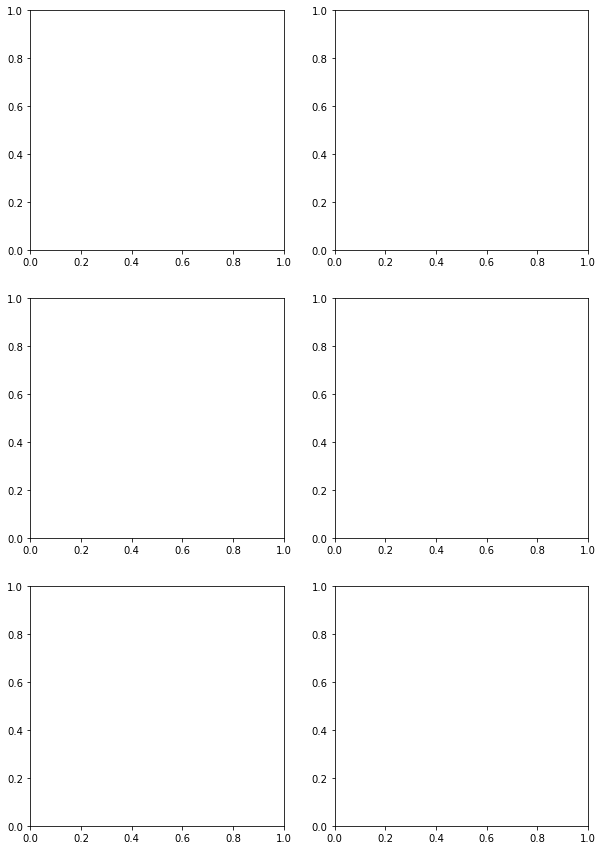

In [22]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [1100]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
elif minmaxfullSampSize:
    samplingsizes_name = ['full_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]   

# 1s time lag
edges_target_names = [['1slag_pull2_pull1','1slag_pull1_pull2'],
                      ['1slag_gaze1_pull1','1slag_gaze2_pull2'],
                      ['1slag_pull2_gaze1','1slag_pull1_gaze2'],]
fromNodesIDs = [[ 9, 8],
                [10,11],
                [ 9, 8],]
toNodesIDs = [[0,1],
              [0,1],
              [2,3]]

#
xplottype = 'succrate' # 'succrate', 'meangazenum'
xplotlabel = 'successful rate' # 'successful rate', 'mean gaze number'
# xplottype = 'meangazenum' # 'succrate', 'meangazenum'
# xplotlabel = 'mean gaze number' # 'successful rate', 'mean gaze number'

n_edges = np.shape(np.array(edges_target_names).flatten())[0]

# figure initiate
fig, axs = plt.subplots(int(np.ceil(n_edges/2)),2)
fig.set_figheight(5*np.ceil(n_edges/2))
fig.set_figwidth(5*2)

#
for i_edge in np.arange(0,n_edges,1):
    #
    edgeweight_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_std_forplot_all_dates = np.zeros((ndates_tgt,1))
    edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_tgt,1))
    
    edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
    fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
    toNodesID = np.array(toNodesIDs).flatten()[i_edge]
    
    for idate in np.arange(0,ndates_tgt,1):
        idate_name = dates_list_tgt[idate]
        
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
    
        edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
        edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
        
      
    # plot 
    if xplottype == 'succrate':
        xxx = succ_rate_all_dates[sorting_tgt_df.index]
    elif xplottype == 'meangazenum':   
        xxx = gazemean_num_all_dates[sorting_tgt_df.index]
    #     
    yyy = edgeweight_mean_forplot_all_dates
    #
    rr_spe,pp_spe = scipy.stats.spearmanr(xxx, yyy)
    slope, intercept, rr_reg, pp_reg, std_err = st.linregress(xxx.astype(float).T[0], yyy.astype(float).T[0])
    #
    axs.flatten()[i_edge].plot(xxx,yyy,'bo',markersize=8)
    axs.flatten()[i_edge].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
    #
    axs.flatten()[i_edge].set_title(edge_tgt_name,fontsize=16)
    axs.flatten()[i_edge].set_ylabel('mean edge weight',fontsize=13)
    axs.flatten()[i_edge].set_ylim([-0.1,1.1])
    #
    if i_edge > int(n_edges-3):
        axs.flatten()[i_edge].set_xlabel(xplotlabel,fontsize=13)
    else:
        axs.flatten()[i_edge].set_xticklabels('')
    #
    # axs.flatten()[i_edge].text(xxx.min(),1.0,'spearman r='+"{:.2f}".format(rr_spe),fontsize=10)
    # axs.flatten()[i_edge].text(xxx.min(),0.9,'spearman p='+"{:.2f}".format(pp_spe),fontsize=10)
    axs.flatten()[i_edge].text(xxx.min(),1.0,'regression r='+"{:.2f}".format(rr_reg),fontsize=10)
    axs.flatten()[i_edge].text(xxx.min(),0.9,'regression p='+"{:.2f}".format(pp_reg),fontsize=10)
    


        
savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweights_vs_"+xplottype+"_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pdf')
    
    

## Plots that include all pairs
####  mean edge weights of selected edges v.s. other behavioral measures
##### only the cooperation days

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_forceManipulation_task_data_saved/data_saved_singlecam_wholebody_bestsessions/camera-2/eddiesparkle//owgaze1_num_all_dates_eddiesparkle.pkl'

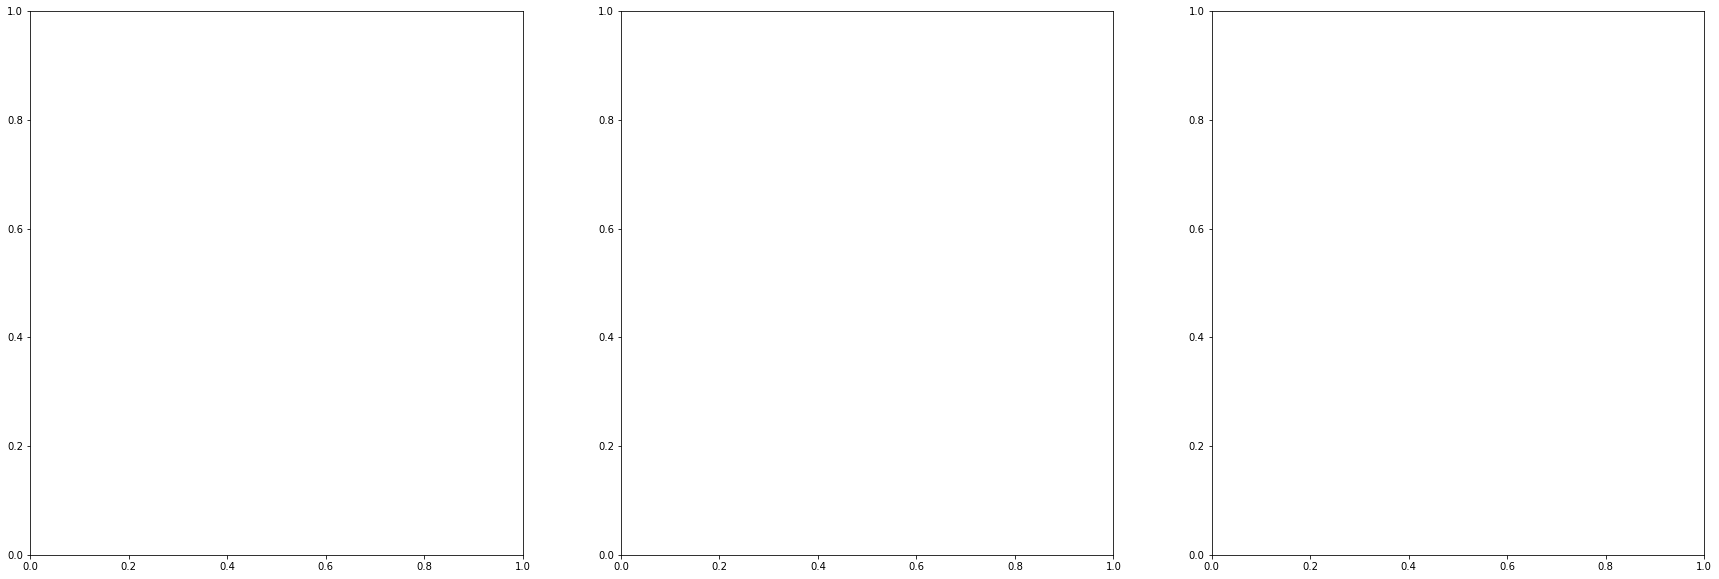

In [23]:
# PLOT multiple pairs in one plot, so need to load data seperately
mergetempRos = 0 # 1: merge different time bins
minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session
moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
nanimalpairs = np.shape(animal1_fixedorders)[0]

#
# DBN analysis types
# 1s time lag
edges_target_names = [['1slag_pull2_pull1','1slag_pull1_pull2'],
                      ['1slag_gaze1_pull1','1slag_gaze2_pull2'],
                      ['1slag_pull2_gaze1','1slag_pull1_gaze2'],]
fromNodesIDs = [[ 9, 8],
                [10,11],
                [ 9, 8],]
toNodesIDs = [[0,1],
              [0,1],
              [2,3]]
n_edges = np.shape(np.array(edges_target_names).flatten())[0]

#
xplottype = 'succrate' # 'succrate', 'meangazenum', 'meanpullnum'
xplotlabel = 'successful rate' # 'successful rate', 'mean gaze number', 'mean pull number'
# xplottype = 'meangazenum' # 'succrate', 'meangazenum', 'meanpullnum'
# xplotlabel = 'mean gaze number' # 'successful rate', 'mean gaze number', 'mean pull number'
# xplottype = 'meanpullnum' # 'succrate', 'meangazenum', 'meanpullnum'
# xplotlabel = 'mean pull number' # 'successful rate', 'mean gaze number', 'mean pull number'

#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)

# initiate the final data set
edges_measure_slopes_all = np.zeros((nanimalpairs,n_edges))
edges_measure_corrR_all = np.zeros((nanimalpairs,n_edges))
edges_measure_regR_all = np.zeros((nanimalpairs,n_edges))

for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    
    # load the basic behavioral measures
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
    # 
    pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
    #
    gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
    gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
    gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

    # load the DBN related analysis
    # load data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    if minmaxfullSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    #
    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    elif minmaxfullSampSize:
        samplingsizes_name = ['full_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]
    #
    # only load one set of analysis parameter
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]  
    
    
    #
    # re-organize the target dates
    # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
    tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
    coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
    coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
    
    
    
    #
    # sort the data based on task type and dates
    dates_list = list(weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)].keys())
    sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
    sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
    #
    # only select the targeted dates
    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
    sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
    dates_list_tgt = sorting_tgt_df['dates']
    dates_list_tgt = np.array(dates_list_tgt)
    #
    ndates_tgt = np.shape(dates_list_tgt)[0]
    
    
    # calculate the linear regression and correlation metrics for tgt edges
    for i_edge in np.arange(0,n_edges,1):
        #
        edgeweight_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
        edgeweight_shuffled_mean_forplot_all_dates = np.zeros((ndates_tgt,1))
        edgeweight_std_forplot_all_dates = np.zeros((ndates_tgt,1))
        edgeweight_shuffled_std_forplot_all_dates = np.zeros((ndates_tgt,1))

        edge_tgt_name = np.array(edges_target_names).flatten()[i_edge]
        fromNodesID = np.array(fromNodesIDs).flatten()[i_edge]
        toNodesID = np.array(toNodesIDs).flatten()[i_edge]

        for idate in np.arange(0,ndates_tgt,1):
            idate_name = dates_list_tgt[idate]

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][idate_name]

            edgeweight_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_tgt[:,fromNodesID,toNodesID])
            edgeweight_shuffled_mean_forplot_all_dates[idate] = np.nanmean(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])
            edgeweight_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_tgt[:,fromNodesID,toNodesID])
            edgeweight_shuffled_std_forplot_all_dates[idate] = np.nanstd(weighted_graphs_shuffled_tgt[:,fromNodesID,toNodesID])

        # calculate correlation and linear regression
        if xplottype == 'succrate':
            xxx = succ_rate_all_dates[sorting_tgt_df.index]
        elif xplottype == 'meangazenum':   
            xxx = gazemean_num_all_dates[sorting_tgt_df.index]
        elif xplottype == 'meanpullnum':   
            xxx = pullmean_num_all_dates[sorting_tgt_df.index]
        #     
        yyy = edgeweight_mean_forplot_all_dates
        #
        rr_spe,pp_spe = scipy.stats.spearmanr(xxx, yyy)
        slope, intercept, rr_reg, pp_reg, std_err = st.linregress(xxx.astype(float).T[0], yyy.astype(float).T[0])
    
        #
        edges_measure_slopes_all[ianimalpair,i_edge] = slope
        edges_measure_corrR_all[ianimalpair,i_edge] = rr_spe
        edges_measure_regR_all[ianimalpair,i_edge] = rr_reg

# plot
edges_measure_slopes_all=np.vstack([edges_measure_slopes_all[:,np.arange(0,n_edges,2)],edges_measure_slopes_all[:,np.arange(1,n_edges,2)]])
edges_measure_corrR_all=np.vstack([edges_measure_corrR_all[:,np.arange(0,n_edges,2)],edges_measure_corrR_all[:,np.arange(1,n_edges,2)]])
edges_measure_regR_all=np.vstack([edges_measure_regR_all[:,np.arange(0,n_edges,2)],edges_measure_regR_all[:,np.arange(1,n_edges,2)]])

# 

dependencytargets = ['pull-pull','within_gazepull','across_pullgaze']
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency
edge_measure_tgt_all = edges_measure_regR_all # regression slope or correlation R or regression R
measure_tgt_name = 'regression_R' # 'regression_slopes' or 'correlation_R' or 'regression_R'
# 
edge_measure_tgt_all_df = pd.DataFrame(edge_measure_tgt_all)
edge_measure_tgt_all_df.columns = dependencytargets
edge_measure_tgt_all_df['type'] = 'all'
#
df_long=pd.concat([edge_measure_tgt_all_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].set_ylabel('edge weight v.s. '+xplotlabel,fontsize=20)
axs.ravel()[0].set_title('all animals; '+measure_tgt_name ,fontsize=24)
# axs.ravel()[0].set_ylim([-2.35,2.35])
axs.ravel()[0].set_ylim([-1,1])

# plot 2
# separating male and female
edge_measure_tgt_male_df = pd.DataFrame(edge_measure_tgt_all[[0,1,2],:])
edge_measure_tgt_male_df.columns = dependencytargets
edge_measure_tgt_male_df['type'] = 'male'
#
edge_measure_tgt_female_df = pd.DataFrame(edge_measure_tgt_all[[3,4,5,6,7],:])
edge_measure_tgt_female_df.columns = dependencytargets
edge_measure_tgt_female_df['type'] = 'female'
#
df_long=pd.concat([edge_measure_tgt_male_df,edge_measure_tgt_female_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].set_ylabel('edge weight v.s. '+xplotlabel,fontsize=20)
axs.ravel()[1].set_title('male vs female; '+measure_tgt_name ,fontsize=24)
# axs.ravel()[1].set_ylim([-2.35,2.35])
axs.ravel()[1].set_ylim([-1,1])

# plot 3
# separating subordinate and dominant
edge_measure_tgt_sub_df = pd.DataFrame(edge_measure_tgt_all[[0,1,2,3],:])
edge_measure_tgt_sub_df.columns = dependencytargets
edge_measure_tgt_sub_df['type'] = 'subordinate'
#
edge_measure_tgt_dom_df = pd.DataFrame(edge_measure_tgt_all[[4,5,6,7],:])
edge_measure_tgt_dom_df.columns = dependencytargets
edge_measure_tgt_dom_df['type'] = 'dominant'
#
df_long=pd.concat([edge_measure_tgt_sub_df,edge_measure_tgt_dom_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].set_ylabel('edge weight v.s. '+xplotlabel,fontsize=20)
axs.ravel()[2].set_title('sub vs dom; '+measure_tgt_name ,fontsize=24)
# axs.ravel()[2].set_ylim([-2.35,2.35])
axs.ravel()[2].set_ylim([-1,1])

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"edgeweights_vs_"+xplottype+"_"+measure_tgt_name+'.pdf')
    

In [ ]:
st.ttest_1samp(edge_measure_tgt_dom_df['pull-pull'],0)

In [24]:
edge_measure_tgt_sub_df

NameError: name 'edge_measure_tgt_sub_df' is not defined

## Plots that include all pairs
####  plot the coorelation between pull time, and social gaze time
#### pull <-> pull; within animal gaze -> pull; across animal pull -> gaze; within animal pull -> gaze

In [25]:
# PLOT multiple pairs in one plot, so need to load data seperately
mergetempRos = 0 # 1: merge different time bins
minmaxfullSampSize = 1 # 1: use the  min row number and max row number, or the full row for each session
moreSampSize = 0 # 1: use more sample size (more than just minimal row number and max row number)
#
animal1_fixedorders = ['eddie','dodson','dannon','ginger']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga']
nanimalpairs = np.shape(animal1_fixedorders)[0]

# initiate the final data set
pull_gaze_time_corr_mean_all = np.zeros((nanimalpairs*2,2))


for ianimalpair in np.arange(0,nanimalpairs,1):
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    
    # load the basic behavioral measures
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
    # 
    pullmean_num_all_dates = (pull1_num_all_dates+pull2_num_all_dates)/2
    #
    gaze1_num_all_dates = owgaze1_num_all_dates + mtgaze1_num_all_dates
    gaze2_num_all_dates = owgaze2_num_all_dates + mtgaze2_num_all_dates
    gazemean_num_all_dates = (gaze1_num_all_dates+gaze2_num_all_dates)/2

    # load the DBN related analysis
    # load data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_allsessions'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    #
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    if minmaxfullSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_minmaxfullSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    #
    if not mergetempRos:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    else:
        with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
            
    #
    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    elif minmaxfullSampSize:
        samplingsizes_name = ['full_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]
    #
    # only load one set of analysis parameter
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]  
    
    
    #
    # re-organize the target dates
    # 100: self; 3: 3s coop; 2: 2s coop; 1.5: 1.5s coop; 1: 1s coop; -1: no-vision
    tasktypes_all_dates[tasktypes_all_dates==5] = -1 # change the task type code for no-vision
    coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
    coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
    
    
    
    #
    # sort the data based on task type and dates
    dates_list = list(weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)].keys())
    sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
    sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
    #
    # only select the targeted dates
    sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)|(sorting_df['coopthres']==1.5)|(sorting_df['coopthres']==2)|(sorting_df['coopthres']==3)]
    # sorting_tgt_df = sorting_df[(sorting_df['coopthres']==1)]
    # sorting_tgt_df = sorting_df
    dates_list_tgt = sorting_tgt_df['dates']
    dates_list_tgt = np.array(dates_list_tgt)
    #
    ndates_tgt = np.shape(dates_list_tgt)[0]
    
    #
    # initiate the final data set
    within_pull_gaze_time_corr_all_ipair = dict.fromkeys(dates_list_tgt,[])
    across_pull_gaze_time_corr_all_ipair = dict.fromkeys(dates_list_tgt,[])
    within_pull_gaze_time_corP_all_ipair = dict.fromkeys(dates_list_tgt,[])
    across_pull_gaze_time_corP_all_ipair = dict.fromkeys(dates_list_tgt,[])

    
    for idate in np.arange(0,ndates_tgt,1):
        idate_name = dates_list_tgt[idate]

        DBN_input_data_idate = DBN_input_data_alltypes[idate_name]
        #
        if 0:
            # single behavioral events  
            # pull1_t0 and gaze1_t0
            xxx1 = (np.array(DBN_input_data_idate['pull1_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
            rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)                 
            # pull2_t0 and gaze1_t0
            xxx1 = (np.array(DBN_input_data_idate['pull2_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t0'])==1)*1
            rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)            
            # pull2_t0 and gaze2_t0
            xxx1 = (np.array(DBN_input_data_idate['pull2_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
            rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)           
            # pull1_t0 and gaze2_t0
            xxx1 = (np.array(DBN_input_data_idate['pull1_t0'])==1)*1
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t0'])==1)*1
            rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
        #
        if 0:
            # single behavioral events with synced pull
            xxx1_1 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['pull1_t1'])==1))*1
            xxx1_2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['pull2_t1'])==1))*1 
            # pull1_t0 and gaze1_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t1'])==1)*1
            rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)                 
            # pull2_t0 and gaze1_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze1_t1'])==1)*1
            rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)            
            # pull2_t0 and gaze2_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t1'])==1)*1
            rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)           
            # pull1_t0 and gaze2_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = (np.array(DBN_input_data_idate['owgaze2_t1'])==1)*1
            rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
        #
        if 1:
            # paired behavioral events
            xxx1_1 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['pull1_t1'])==1))*1
            xxx1_2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['pull2_t1'])==1))*1            
            # pull1_t1 and gaze1_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull1_t1'])==1)&(np.array(DBN_input_data_idate['owgaze1_t0'])==1))*1
            #
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr1_spe,pp1_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr1_spe = np.nan
                pp1_spe = np.nan            
            # pull2_t0 and gaze1_t1
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull2_t0'])==1)&(np.array(DBN_input_data_idate['owgaze1_t1'])==1))*1
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr2_spe,pp2_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr2_spe = np.nan
                pp2_spe = np.nan        
            # pull2_t1 and gaze2_t0
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull2_t1'])==1)&(np.array(DBN_input_data_idate['owgaze2_t0'])==1))*1
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr3_spe,pp3_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr3_spe = np.nan
                pp3_spe = np.nan           
            # pull1_t0 and gaze2_t1
            xxx1 = xxx1_1 + xxx1_2
            xxx2 = ((np.array(DBN_input_data_idate['pull1_t0'])==1)&(np.array(DBN_input_data_idate['owgaze2_t1'])==1))*1
            try:
                xxx_plot = np.linspace(0, np.shape(xxx1)[0], np.shape(xxx1)[0])
                xxx1 = np.where(xxx1==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx1.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx1 = np.exp(log_dens)
                #
                xxx_plot = np.linspace(0, np.shape(xxx2)[0], np.shape(xxx2)[0])
                xxx2 = np.where(xxx2==1)[0]
                kde = KernelDensity(kernel="gaussian", bandwidth=1).fit(xxx2.reshape(-1, 1))
                log_dens = kde.score_samples(xxx_plot.reshape(-1, 1))
                xxx2 = np.exp(log_dens)
                #
                rr4_spe,pp4_spe = scipy.stats.spearmanr(xxx1, xxx2)
            except:
                rr4_spe = np.nan
                pp4_spe = np.nan
  
            
        #    
        within_pull_gaze_time_corr_all_ipair[idate_name] = [rr1_spe,rr3_spe]
        across_pull_gaze_time_corr_all_ipair[idate_name] = [rr2_spe,rr4_spe]
        within_pull_gaze_time_corP_all_ipair[idate_name] = [pp1_spe,pp3_spe]
        across_pull_gaze_time_corP_all_ipair[idate_name] = [pp2_spe,pp4_spe]
    
    # organize the data to the summarizing mean variables
    pull_gaze_time_corr_mean_all[[ianimalpair*2,ianimalpair*2+1],0]=np.nanmean(pd.DataFrame(within_pull_gaze_time_corr_all_ipair),axis=1)
    pull_gaze_time_corr_mean_all[[ianimalpair*2,ianimalpair*2+1],1]=np.nanmean(pd.DataFrame(across_pull_gaze_time_corr_all_ipair),axis=1)

    
    # plot each animal pair first
    # figure initiate
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(5*2)
    fig.set_figwidth(10*2)
    #
    plottype_names = ['within animal gaze to pull, '+animal1_fixedorder,
                      'across animal pull to gaze, '+animal1_fixedorder,
                      'within animal gaze to pull, '+animal2_fixedorder,
                      'across animal pull to gaze, '+animal2_fixedorder]
    plotCorrs_pooled = [
                        np.array(pd.DataFrame(within_pull_gaze_time_corr_all_ipair).T)[:,0],
                        np.array(pd.DataFrame(across_pull_gaze_time_corr_all_ipair).T)[:,0],
                        np.array(pd.DataFrame(within_pull_gaze_time_corr_all_ipair).T)[:,1],
                        np.array(pd.DataFrame(across_pull_gaze_time_corr_all_ipair).T)[:,1],
                       ]
    #
    for iplot in np.arange(0,4,1):
        #
        plottype_name = plottype_names[iplot]
        plotCorrs = plotCorrs_pooled[iplot]
        
        # plot 
        axs.flatten()[iplot].plot(np.arange(0,ndates_tgt,1),plotCorrs,'ko',markersize=10)
        #
        axs.flatten()[iplot].set_title(plottype_name,fontsize=16)
        axs.flatten()[iplot].set_ylabel('time coorelation with pull <-> pull',fontsize=13)
        axs.flatten()[iplot].set_ylim([-1.1,1.1])
        axs.flatten()[iplot].set_xlim([-0.5,ndates_tgt-0.5])
        #
        if iplot > 1:
            axs.flatten()[iplot].set_xticks(np.arange(0,ndates_tgt,1))
            axs.flatten()[iplot].set_xticklabels(dates_list_tgt, rotation=90,fontsize=10)
        else:
            axs.flatten()[iplot].set_xticklabels('')
        #
        # tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)','no-vision']
        tasktypes = ['coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
        taskswitches = np.where(np.array(sorting_tgt_df['coopthres'])[1:]-np.array(sorting_tgt_df['coopthres'])[:-1]!=0)[0]+0.5
        for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
            taskswitch = taskswitches[itaskswitch]
            axs.flatten()[iplot].plot([taskswitch,taskswitch],[-1.1,1.1],'k--')
        taskswitches = np.concatenate(([0],taskswitches))
        for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
            taskswitch = taskswitches[itaskswitch]
            axs.flatten()[iplot].text(taskswitch+0.25,-0.9,tasktypes[itaskswitch],fontsize=10)
        axs.flatten()[iplot].plot([0,ndates_tgt],[0,0],'k--')

    savefigs = 1
    if savefigs:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'       
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+'syncedpulltime_pullgazetime_correlation_'+animal1_fixedorder+animal2_fixedorder+'.pdf')
    
    
    
    
# plot the summarizing figure
#
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10*3)

dependencytargets = ['within_gazepull','across_pullgaze']
# dependencytargets = dependencynames

# plot 1
# average all animals for each dependency
pull_gaze_time_corr_tgt_all = pull_gaze_time_corr_mean_all 
measure_tgt_name = 'time point correlation' 
# 
pull_gaze_time_corr_tgt_all_df = pd.DataFrame(pull_gaze_time_corr_tgt_all)
pull_gaze_time_corr_tgt_all_df.columns = dependencytargets
pull_gaze_time_corr_tgt_all_df['type'] = 'all'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_all_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[0],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[0].set_xlabel('')
axs.ravel()[0].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[0].set_title('all animals' ,fontsize=24)
# axs.ravel()[0].set_ylim([-2.35,2.35])
axs.ravel()[0].set_ylim([-1,1])

# plot 2
# separating male and female
pull_gaze_time_corr_tgt_male_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[0,2,4],:])
pull_gaze_time_corr_tgt_male_df.columns = dependencytargets
pull_gaze_time_corr_tgt_male_df['type'] = 'male'
#
pull_gaze_time_corr_tgt_female_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[1,3,5,6,7],:])
pull_gaze_time_corr_tgt_female_df.columns = dependencytargets
pull_gaze_time_corr_tgt_female_df['type'] = 'female'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_male_df,pull_gaze_time_corr_tgt_female_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[1],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[1].set_xlabel('')
axs.ravel()[1].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[1].set_title('male vs female' ,fontsize=24)
# axs.ravel()[1].set_ylim([-2.35,2.35])
axs.ravel()[1].set_ylim([-1,1])

# plot 3
# separating subordinate and dominant
pull_gaze_time_corr_tgt_sub_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[0,2,4,6],:])
pull_gaze_time_corr_tgt_sub_df.columns = dependencytargets
pull_gaze_time_corr_tgt_sub_df['type'] = 'subordinate'
#
pull_gaze_time_corr_tgt_dom_df = pd.DataFrame(pull_gaze_time_corr_tgt_all[[1,3,5,7],:])
pull_gaze_time_corr_tgt_dom_df.columns = dependencytargets
pull_gaze_time_corr_tgt_dom_df['type'] = 'dominant'
#
df_long=pd.concat([pull_gaze_time_corr_tgt_sub_df,pull_gaze_time_corr_tgt_dom_df])
df_long2 = df_long.melt(id_vars=['type'], value_vars=dependencytargets,var_name='condition', value_name='value')
# barplot ans swarmplot
seaborn.barplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',errorbar='se',alpha=.5,capsize=0.1)
seaborn.swarmplot(ax=axs.ravel()[2],data=df_long2,x='condition',y='value',hue='type',alpha=.9,size= 9,dodge=True,legend=False)
axs.ravel()[2].set_xlabel('')
axs.ravel()[2].set_ylabel(measure_tgt_name,fontsize=20)
axs.ravel()[2].set_title('sub vs dom' ,fontsize=24)
# axs.ravel()[2].set_ylim([-2.35,2.35])
axs.ravel()[2].set_ylim([-1,1])


savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"syncedpulltime_pullgazetime_correlation_summaryplot.pdf")


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_forceManipulation_task_data_saved/data_saved_singlecam_wholebody_bestsessions/camera-2/eddiesparkle//owgaze1_num_all_dates_eddiesparkle.pkl'